# siRNA data

In [43]:
setwd("~/work/fibroblast_timecourse")

In [44]:
source("R/001_libraries_data.R")
source("R/002_helper_functions.R")

load(data/gene_sets.rda)
load(data/rnaseq_kallisto_ensembl89.rda)
load(data/rnaseq-sirna_kallisto_ensembl89.rda)
fread('gunzip -c %s')data-raw/ensembl89/Homo_sapiens.GRCh38.89.gene_names.tsv.gz
library(tftargets)


In [45]:
pacman::p_load(
  seriation,
  fractional,
  forcats
)

In [46]:
# Return a dataframe where 'col1' and 'col2' are factors with levels in order.
seriate_cols <- function(d, col1, col2, value.var = "percent", method = "BEA_TSP") {
  mat <- as.data.frame(dcast(
    data      = d,
    formula   = as.formula(sprintf("%s ~ %s", col1, col2)),
    value.var = value.var,
    fun.aggregate = mean
  ))
  rownames(mat) <- mat[[1]]
  mat[[1]] <- NULL
  mat <- as.matrix(mat)
  mat[is.na(mat)] <- 0
  mat_order <- seriate(mat, method = method)
  d[[col1]] <- factor(as.character(d[[col1]]), rownames(mat)[mat_order[[1]]])
  d[[col2]] <- factor(as.character(d[[col2]]), colnames(mat)[mat_order[[2]]])
  return(d)
}

In [47]:
theme_set(theme_classic(base_size = 18) %+replace% theme(strip.background = element_blank(),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5)
))

In [48]:
sirnas <- c("CUX1", "ELF3", "LIFR", "STAT3", "STAT4")

meta_colors$sirna <- c(
  "Ctrl"  = "black",
  "CUX1"  = '#1B9E77',
  "STAT3" = '#D95F02',
  "STAT4" = '#7570B3',
  "ELF3"  = '#E7298A',
  "LIFR"  = '#66A61E'
)

meta_colors$Stimulation <- c(
  "None" = "grey50",
  "TNF (1)" = "#FEB24C",
  "TNF (1) + IL17 (1)" = "#E31A1C",
  "TNF (1) + IL17 (10)" = "#800026"
)

meta_colors$dosefactor <- c(
  "0" = meta_colors$Stimulation[["TNF (1)"]],
  "1" = meta_colors$Stimulation[["TNF (1) + IL17 (1)"]],
  "10" = meta_colors$Stimulation[["TNF (1) + IL17 (10)"]]
)

In [49]:
dput(meta_colors$Stimulation)

structure(c("grey50", "#FEB24C", "#E31A1C", "#800026"), .Names = c("None", 
"TNF (1)", "TNF (1) + IL17 (1)", "TNF (1) + IL17 (10)"))


# Export for NCBI GEO

In [101]:
sirna$counts[1:5,1:5]
sirna$countst[1:5,1:5]

,000008520469_A01,000008520469_B01,000008520469_C01,000008520469_D01,000008520469_E01
ENSG00000004059,633.999600,492.8626,686.99969,382.94468,765.99972
ENSG00000003056,876.992830,992.3097,1154.42139,610.64995,1418.09570
ENSG00000173153,5.193361,9.0000,17.00491,11.01832,5.00509
ENSG00000004478,275.551240,335.0005,323.99991,163.00003,243.86822
ENSG00000003137,2.000000,5.0000,4.00000,12.00002,0.00000


,000008520469_A01,000008520469_B01,000008520469_C01,000008520469_D01,000008520469_E01
ENST00000000233,622.9230,479.32700,679.0440,380.21800,763.27100
ENST00000000412,796.7300,897.72900,1033.1100,594.11700,1386.68000
ENST00000000442,4.3369,7.61282,14.3267,9.35894,4.28025
ENST00000001008,252.7240,299.87400,297.3320,161.76400,228.02700
ENST00000001146,0.0000,0.00000,0.0000,12.00000,0.00000


In [102]:
table(str_split_fixed(colnames(sirna$counts), "_", 2)[,1])


000008519369 000008520469 
          96           96 

In [112]:
write_matrix <- function(x, path) {
  colnames(x) <- sprintf("S%s", 1:ncol(x))
  x <- data.frame(
    ID_REF = rownames(x),
    x,
    stringsAsFactors = FALSE
  )
  rownames(x) <- NULL
  readr::write_tsv(x, path)
  print(path)
  cat(paste(system(sprintf("zcat %s | head | cut -f1-5 | column -t", path), intern = TRUE), collapse = "\n"))
  cat("\n\n")
}

###

out_dir <- "share/NCBI-GEO/rnaseq-data-2"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

gene_counts_file <- sprintf("%s/rnaseq-data-2_gene-counts.tsv.gz", out_dir)
write_matrix(sirna$counts, gene_counts_file)

gene_tpm_file <- sprintf("%s/rnaseq-data-2_gene-tpm.tsv.gz", out_dir)
write_matrix(sirna$tpm, gene_tpm_file)

transcript_counts_file <- sprintf("%s/rnaseq-data-2_transcript-counts.tsv.gz", out_dir)
write_matrix(sirna$countst, transcript_counts_file)

transcript_tpm_file <- sprintf("%s/rnaseq-data-2_transcript-tpm.tsv.gz", out_dir)
write_matrix(sirna$tpmt, transcript_tpm_file)

###

sirna$meta$plate <- 2
ix <- str_split_fixed(sirna$meta$sample, "_", 2)[,1] == "000008519369"
sirna$meta$plate[ix] <- 1

all(colnames(sirna$counts) == sirna$meta$sample)
all(colnames(sirna$countst) == sirna$meta$sample)

all(colnames(sirna$tpm) == sirna$meta$sample)
all(colnames(sirna$tpmt) == sirna$meta$sample)

sirna$meta$sample2 <- sprintf("S%s", 1:nrow(sirna$meta))

meta_cols <- c(
  "sample2",
  "donor",
  "sirna",
  "time",
  "stimulation",
  "plate"
)
x <- sirna$meta[,meta_cols]
colnames(x)[1] <- "sample"
meta_file <- sprintf("%s/rnaseq-data-2_metadata.tsv", out_dir)
readr::write_tsv(x, meta_file)

print(meta_file)
cat(paste(system(sprintf("cat %s | head | column -t -s$'\t'", meta_file), intern = TRUE), collapse = "\n"))
cat("\n\n")


[1] "share/NCBI-GEO/rnaseq-data-2/rnaseq-data-2_gene-counts.tsv.gz"
ID_REF           S1                  S2                  S3                  S4
ENSG00000004059  633.9996            492.8626            686.99969           382.94468
ENSG00000003056  876.9928300315308   992.3097            1154.4213914048999  610.649949
ENSG00000173153  5.193361            9                   17.004910000000002  11.018320000000001
ENSG00000004478  275.55124           335.00050000000005  323.99991           163.00003
ENSG00000003137  2                   5                   4                   12.0000172035
ENSG00000003509  147.78811000000002  136.73000000000002  157.51077           111.36097
ENSG00000001036  1329.81             1224.66343          1412.53172          720.40902
ENSG00000003249  5.056712946         8.0889090393        0                   8.053301300000001
ENSG00000002587  18.140408           0                   8.060027            10.0585

[1] "share/NCBI-GEO/rnaseq-data-2/rnaseq-data-2_

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "share/NCBI-GEO/rnaseq-data-2/rnaseq-data-2_metadata.tsv"
sample  donor  sirna  time  stimulation         plate
S1      RA5    Ctrl   0     None                2
S2      RA5    Ctrl   0     None                2
S3      RA5    Ctrl   1     TNF (1)             2
S4      RA5    Ctrl   1     TNF (1) + IL17 (1)  2
S5      RA5    Ctrl   6     TNF (1)             2
S6      RA5    Ctrl   6     TNF (1) + IL17 (1)  2
S7      RA5    Ctrl   16    TNF (1)             2
S8      RA5    Ctrl   16    TNF (1) + IL17 (1)  2
S9      RA5    CUX1   0     None                2



## Experimental Design

In [50]:
mean(c(0.6,0.125))

[1] 0.3625

In [52]:
options(repr.plot.width = 2, repr.plot.height = 1.5)

meta_colors$Stimulation[["None"]] <- "grey90"

tt1 <- gridExtra::ttheme_minimal(core=list(fg_params=list(hjust = 1, x = 0.9)))

stims <- data.frame(
  check.names = FALSE,
  blank = c("", "", "", ""),
  TNF = rev(c(0, 1, 1, "TNF")),
  "IL-17" = rev(c(0, 0, 1, "IL-17"))
)

g <- gridExtra::tableGrob(d = stims, theme = tt1, cols = NULL, rows = NULL)

g <- gtable::gtable_add_grob(
  x = g,
  grobs = grid::grobTree(
    grid::circleGrob(
      x = unit(0.2,"npc"),
      y = unit(0.6,"npc"),
      r = unit(0.1,"npc"),
      gp = grid::gpar(lwd = 0.3, fill = meta_colors$Stimulation[["TNF (1) + IL17 (1)"]])
    ),
    grid::circleGrob(
      x = unit(0.2,"npc"),
      y = unit(0.3625,"npc"),
      r = unit(0.1,"npc"),
      gp = grid::gpar(lwd = 0.3, fill = meta_colors$Stimulation[["TNF (1)"]])
    ),
    grid::circleGrob(
      x = unit(0.2,"npc"),
      y = unit(0.125,"npc"),
      r = unit(0.1,"npc"),
      gp = grid::gpar(lwd = 0.3, fill = meta_colors$Stimulation[["None"]])
    )
  ),
  t = 1, b = 4, l = 1, r = 2
)

# grid::grid.draw(g)

In [53]:
table(sirna$meta$time, sirna$meta$sirna)

    
     Ctrl CUX1 ELF3 LIFR STAT3 STAT4
  0     8    8    8    8     8     8
  1     8    8    8    8     8     8
  6     8    8    8    8     8     8
  16    8    8    8    8     8     8

In [54]:
data.frame(
  xmin = seq(-0.6, 0.6, length.out = 6),
  xmax = seq(3.4, 4.6, length.out = 6),
  ymin = seq(0.2, -0.8, length.out = 6),
  ymax = seq(8.5, 7.5, length.out = 6)
)

xmin,xmax,ymin,ymax
-0.60,3.40,0.2,8.5
-0.36,3.64,0.0,8.3
-0.12,3.88,-0.2,8.1
0.12,4.12,-0.4,7.9
0.36,4.36,-0.6,7.7
0.60,4.60,-0.8,7.5


In [55]:
rbind(
    data.frame(xmin = 0.5 - 1.0, xmax = 4.5 - 1.0, ymin = -0.8 + 1.0, ymax = 7.5 + 1.0),
    data.frame(xmin = 0.5 - 0.8, xmax = 4.5 - 0.8, ymin = -0.8 + 0.8, ymax = 7.5 + 0.8),
    data.frame(xmin = 0.5 - 0.6, xmax = 4.5 - 0.6, ymin = -0.8 + 0.6, ymax = 7.5 + 0.6),
    data.frame(xmin = 0.5 - 0.4, xmax = 4.5 - 0.4, ymin = -0.8 + 0.4, ymax = 7.5 + 0.4),
    data.frame(xmin = 0.5 - 0.2, xmax = 4.5 - 0.2, ymin = -0.8 + 0.2, ymax = 7.5 + 0.2),
    data.frame(xmin = 0.5 - 0.0, xmax = 4.5 - 0.0, ymin = -0.8 + 0.0, ymax = 7.5 + 0.0)
  )

xmin,xmax,ymin,ymax
-0.5,3.5,0.2,8.5
-0.3,3.7,0.0,8.3
-0.1,3.9,-0.2,8.1
0.1,4.1,-0.4,7.9
0.3,4.3,-0.6,7.7
0.5,4.5,-0.8,7.5


In [56]:
-0.8+1.4

[1] 0.6

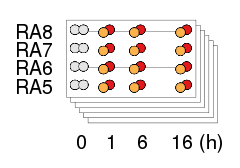

In [57]:
options(repr.plot.width = 2, repr.plot.height = 1.4)

sirna$meta$TEMP <- sirna$meta$stimulation
sirna$meta$TEMP[sirna$meta$TEMP == "None"] <- "TNF (1) + IL17 (1)"

sirna$meta$TEMP2 <- sirna$meta$time
sirna$meta$TEMP2[sirna$meta$TEMP2 == 0] <- rep(c(-0.25, 0.3), 24)
sirna$meta$TEMP2[sirna$meta$TEMP2 == 1] <- 2
sirna$meta$TEMP2[sirna$meta$TEMP2 == 6] <- 4
sirna$meta$TEMP2[sirna$meta$TEMP2 == 16] <- 7
sirna$meta$TEMP2[sirna$meta$stimulation == "TNF (1)"] <- sirna$meta$TEMP2[sirna$meta$stimulation == "TNF (1)"] - 0.4

sirna$meta$TEMP3 <- as.integer(factor(sirna$meta$donor))


p <- ggplot() +
geom_rect(
  data = data.frame(
    xmin = seq(-1, 0.4, length.out = 6),
    xmax = seq(3.2, 4.6, length.out = 6),
    ymin = seq(0.6, -0.8, length.out = 6),
    ymax = seq(9, 7.6, length.out = 6)
  ),
  mapping = aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
  fill = "white",
  color = "black",
  size = 0.1
) +
geom_segment(
  data = sirna$meta,
  mapping = aes(y = 0, yend = 7L, x = TEMP3, xend = TEMP3),
  size = 0.01, alpha = 0.1
) +
geom_point(
  data = sirna$meta,
  mapping = aes(y = TEMP2, x = TEMP3, group = paste(TEMP), fill = stimulation),
  shape = 21, stroke = 0.2,
  size = 2.5,
  position = position_dodge(width = 0.3)
) +
coord_flip() +
scale_fill_manual(
  name = NULL,
  labels = c(
    "None"                = "None",
    "TNF (1)"             = "TNF (1)",
    "TNF (1) + IL17 (1)"  = "TNF (1) and IL-17 (1)"
  ),
  values = meta_colors$Stimulation,
  guide = guide_legend(reverse = TRUE, override.aes = list(size = 4))
) +
scale_x_continuous(
  breaks = 1:4,
  labels = c("RA5", "RA6", "RA7", "RA8")
) +
scale_y_continuous(
  breaks = c(0L, 2L, 4L, 7L),
  labels = c("0", "1", "6", "16 (h)")
) +
theme(
  axis.text.x = element_text(hjust = 0.3),
  legend.position = "none",
  axis.ticks.length = unit(0, "cm"),
  legend.spacing = margin(t = 0, unit = "cm"),
  legend.margin = margin(t = 0, unit = 'cm'),
  axis.text = element_text(size = 12, color = "black"),
  legend.text = element_text(size = 12),
  panel.border = element_blank(),
  axis.line.x = element_blank(),
  axis.line.y = element_blank(),
  axis.ticks = element_blank()
) +
labs(x = NULL, y = NULL)

# show_plot(
#   gridExtra::grid.arrange(p, g, nrow = 1, widths = c(2, 1.2)),
# )
show_plot(p, name = "rnaseq-data-2-design")
# p

In [58]:
nrow(sirna$meta)
nrow(m)

[1] 192

[1] 175

## Share the 0 time point

In [59]:
# Copy the 0 time point for doses 1 and 10
t0 <- subset(sirna$meta, time == 0)
n0 <- nrow(t0)
t0$dosefactor <- 1
sirna$meta_zero <- rbind(t0, sirna$meta)

In [60]:
table(sirna$meta_zero$dosefactor, sirna$meta_zero$time, sirna$meta_zero$sirna)

, ,  = Ctrl

   
    0 1 6 16
  0 8 4 4  4
  1 8 4 4  4

, ,  = CUX1

   
    0 1 6 16
  0 8 4 4  4
  1 8 4 4  4

, ,  = ELF3

   
    0 1 6 16
  0 8 4 4  4
  1 8 4 4  4

, ,  = LIFR

   
    0 1 6 16
  0 8 4 4  4
  1 8 4 4  4

, ,  = STAT3

   
    0 1 6 16
  0 8 4 4  4
  1 8 4 4  4

, ,  = STAT4

   
    0 1 6 16
  0 8 4 4  4
  1 8 4 4  4


### Remove batch effects

Subtract the means of donors and plates to remove most of the batch effects.

Note: This means we can no longer look for differences between OA and RA, since all donors will be centered.

In [61]:
sirna$log2tpm_batch <- removeBatchEffect(x = sirna$log2tpm, batch = sirna$meta$donor)
sirna$log2tpm_zero <- sirna$log2tpm_batch[,as.character(sirna$meta_zero$sample)]

In [62]:
stopifnot(all(colnames(sirna$log2tpm) == sirna$meta$sample))
stopifnot(all(colnames(sirna$log2tpm_zero) == sirna$meta_zero$sample))

## How does siRNA affect TNF+IL17 synergy?

In [63]:
sirna$meta_zero$dosetime <- sprintf("d%st%s", sirna$meta_zero$dosefactor, sirna$meta_zero$timefactor)

sirna$meta_zero$sirnatime <- with(sirna$meta_zero, sprintf("%st%s", sirna, time))

sirna$meta_zero$sirna_dose <- with(sirna$meta_zero, sprintf("%s_%s", sirna, dosefactor))

sirna$meta_zero$time2 <- sirna$meta_zero$time ^ 2


In [64]:
sirna$meta$dosetime <- sprintf("d%st%s", sirna$meta$dosefactor, sirna$meta$timefactor)

sirna$meta$sirnatime <- with(sirna$meta, sprintf("%st%s", sirna, time))

sirna$meta$sirna_dose <- with(sirna$meta, sprintf("%s_%s", sirna, dosefactor))

sirna$meta$time2 <- sirna$meta$time ^ 2

head(sirna$meta)

sample,donor,sirna,time,stimulation,timefactor,dosefactor,TEMP,TEMP2,TEMP3,dosetime,sirnatime,sirna_dose,time2
000008520469_A01,RA5,Ctrl,0,None,0,0,TNF (1) + IL17 (1),-0.25,1,d0t0,Ctrlt0,Ctrl_0,0
000008520469_B01,RA5,Ctrl,0,None,0,0,TNF (1) + IL17 (1),0.30,1,d0t0,Ctrlt0,Ctrl_0,0
000008520469_C01,RA5,Ctrl,1,TNF (1),1,0,TNF (1),1.60,1,d0t1,Ctrlt1,Ctrl_0,1
000008520469_D01,RA5,Ctrl,1,TNF (1) + IL17 (1),1,1,TNF (1) + IL17 (1),2.00,1,d1t1,Ctrlt1,Ctrl_1,1
000008520469_E01,RA5,Ctrl,6,TNF (1),6,0,TNF (1),3.60,1,d0t6,Ctrlt6,Ctrl_0,36
000008520469_F01,RA5,Ctrl,6,TNF (1) + IL17 (1),6,1,TNF (1) + IL17 (1),4.00,1,d1t6,Ctrlt6,Ctrl_1,36


In [65]:
table(sirna$meta$sirna, sirna$meta$dosefactor)

       
         0  1
  Ctrl  20 12
  CUX1  20 12
  ELF3  20 12
  LIFR  20 12
  STAT3 20 12
  STAT4 20 12

# The main model

In [66]:
sirna$meta$dosetime <- factor(
  as.character(sirna$meta$dosetime),
  c("d0t0", "d0t1", "d0t6", "d0t16", "d1t1", "d1t6", "d1t16")
)

In [67]:
sirna$ix_nonzero <- which(sirna$meta$time > 0)

sirna$rowmeans <- rowMeans(sirna$log2tpm)
sirna$ix_mean <- sirna$rowmeans > quantile(sirna$rowmeans, probs = 0.25)
sirna$ix_mean <- rep(TRUE, nrow(sirna$log2tpm))
sirna$log2tpm_batch <- removeBatchEffect(
  sirna$log2tpm[sirna$ix_mean,],
  batch = sirna$meta$donor
#   batch2 = substr(sirna$meta$sample, 14, 14)
)

clean_cols <- function(x) {
  colnames(x) <- str_replace_all(colnames(x), "[()]", "")
  colnames(x) <- str_replace_all(colnames(x), ":", "")
  colnames(x) <- str_replace_all(colnames(x), regex("DoseFactor", ignore_case = TRUE), "d")
  colnames(x) <- str_replace_all(colnames(x), "DoseExposure", "d")
  colnames(x) <- str_replace_all(colnames(x), "TimeFactor", "t")
  colnames(x) <- str_replace_all(colnames(x), "TRUE", "1")
  colnames(x) <- str_replace_all(colnames(x), "sirna", "")
  colnames(x) <- str_replace_all(colnames(x), "dosetime", "")
  return(x)
}
sirna$des1 <- clean_cols(with(
  sirna$meta,
#   model.matrix(~ 0 + dosetime + sirna)
    model.matrix(~ dosetime + sirna)
#   model.matrix(~ time + I(time^2) + dosefactor + sirna)
))
sirna$fit1 <- lmFit(object = sirna$log2tpm, design = sirna$des1)
# sirna$fit1 <- lmFit(object = sirna$log2tpm, design = sirna$des1)
sirna$fit1 <- eBayes(sirna$fit1)
sirna$fit1$genes <- gene_symbols[rownames(sirna$fit1$coefficients)]

print(colnames(sirna$des1))

sirna$fit1_top <- rbindlist(lapply(colnames(sirna$des1), function(this_sirna) {
  retval <- topTable(sirna$fit1, coef = this_sirna, confint = TRUE, number = 1e6)
  retval$ensembl_id <- rownames(retval)
  retval$Coef <- this_sirna
  retval
}))

sirna$fit1_top %<>% mutate(
  FC   = 1 / 2^logFC,
  FC.R = 1 / 2^CI.L,
  FC.L = 1 / 2^CI.R
) 

head(sirna$fit1_top)

sirna$fit1_top %>%
filter(ID %in% c("CXCL1", "CXCL2", "CXCL3", "CXCL8", "CUX1")) %>%
select(ID, logFC, P.Value, adj.P.Val, Coef, FC) %>%
head()

 [1] "Intercept" "d0t1"      "d0t6"      "d0t16"     "d1t1"      "d1t6"     
 [7] "d1t16"     "CUX1"      "ELF3"      "LIFR"      "STAT3"     "STAT4"    


ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
HSP90AA1,8.969691,8.861789,9.077593,8.711705,164.0223,4.199370e-199,1.213114e-194,443.7367,ENSG00000080824,Intercept,1.994592e-03,2.149492e-03,1.850854e-03
ATP6V0E1,9.240454,9.125959,9.354948,9.111144,159.2446,8.619467e-197,1.244996e-192,438.6129,ENSG00000113732,Intercept,1.653279e-03,1.789833e-03,1.527144e-03
B2M,12.392492,12.231312,12.553671,12.775884,151.7068,5.326699e-193,5.129256e-189,430.1858,ENSG00000166710,Intercept,1.859895e-04,2.079736e-04,1.663292e-04
FTH1,14.000026,13.810109,14.189944,14.217282,145.4519,1.036956e-189,7.488894e-186,422.8487,ENSG00000167996,Intercept,6.103405e-05,6.962146e-05,5.350585e-05
VIM,12.358288,12.183238,12.533338,12.360596,139.3005,2.450082e-186,1.415559e-182,415.3016,ENSG00000026025,Intercept,1.904516e-04,2.150205e-04,1.686900e-04
PCOLCE,9.699008,9.558121,9.839895,9.378592,135.8349,2.262893e-184,1.089507e-180,410.8946,ENSG00000106333,Intercept,1.203116e-03,1.326536e-03,1.091180e-03


ID,logFC,P.Value,adj.P.Val,Coef,FC
CUX1,4.9752419,5.476120e-70,3.904101e-69,Intercept,0.031790909
CXCL1,1.6049966,6.307322e-12,1.523461e-11,Intercept,0.328736471
CXCL2,0.9804978,7.366077e-09,1.670392e-08,Intercept,0.506804850
CXCL3,0.6088697,1.339239e-04,2.539745e-04,Intercept,0.655710236
CXCL8,0.6896865,9.575181e-03,1.528051e-02,Intercept,0.619988561
CXCL3,6.7469537,2.805309e-87,8.103976e-83,d0t1,0.009310319


In [93]:
# my_genes <- c("CXCL1", "CXCL2", "CXCL3", "CXCL6", "CXCL8", "C15orf48")
my_genes <- c("CXCL1", "CXCL2", "CXCL3", "CXCL6", "CXCL8")

sirna$fit1_top %>%
filter(Coef %in% c("CUX1")) %>%
filter(ID %in% my_genes) %>%
summarise(
  mean = 2^mean(logFC),
  sem  = (2^sd(logFC)) / sqrt(length(logFC) - 1),
  low  = 2^mean(CI.L),
  high = 2^mean(CI.R)
) %>%
mutate_if(is.numeric, function(x) signif(x, 2))

sirna$fit1_top %>%
filter(Coef %in% c("LIFR", "STAT3", "STAT4", "ELF3")) %>%
filter(ID %in% my_genes) %>%
summarise(
  mean = 2^mean(logFC),
  sem  = (2^sd(logFC)) / sqrt(length(logFC) - 1),
  low  = 2^mean(CI.L),
  high = 2^mean(CI.R)
) %>%
mutate_if(is.numeric, function(x) signif(x, 2))
          
sirna$fit1_top %>%
filter(Coef %in% c("LIFR")) %>%
filter(ID %in% my_genes) %>%
summarise(
  mean = 2^mean(logFC),
  sem  = (2^sd(logFC)) / sqrt(length(logFC) - 1),
  low  = 2^mean(CI.L),
  high = 2^mean(CI.R)
) %>%
mutate_if(is.numeric, function(x) signif(x, 2))

mean,sem,low,high
0.6,0.58,0.43,0.84


mean,sem,low,high
0.92,0.27,0.66,1.3


mean,sem,low,high
0.95,0.55,0.68,1.3


In [74]:
my_genes <- c("TNFRSF1A")

cat("Effect of si-CUX1")
sirna$fit1_top %>%
filter(Coef %in% c("CUX1")) %>%
filter(ID %in% my_genes) %>%
head()

cat("Effect of other siRNAs")
sirna$fit1_top %>%
filter(Coef %in% c("LIFR", "STAT3", "STAT4", "ELF3")) %>%
filter(ID %in% my_genes) %>%
summarise(
  mean = 2^mean(logFC),
  sem  = (2^sd(logFC)) / sqrt(length(logFC) - 1),
  low  = 2^mean(CI.L),
  high = 2^mean(CI.R)
)

Effect of si-CUX1

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
TNFRSF1A,-0.6199862,-0.9969824,-0.24299,7.062239,-3.244897,0.001399096,0.03548472,-1.362938,ENSG00000067182,CUX1,1.53686,1.995821,1.183443


Effect of other siRNAs

mean,sem,low,high
0.9677447,0.7448327,0.7452013,1.256747


In [91]:
# my_genes <- c("CCL7", "CCL8", "CCL20")
my_genes <- c("CCL8", "CCL20", "STC1", "MMP3")

sirna$fit1_top %>%
filter(Coef %in% c("LIFR", "STAT3")) %>%
filter(ID %in% my_genes) %>%
head()

print(my_genes)

print("LIFR and STAT3")
sirna$fit1_top %>%
filter(Coef %in% c("LIFR", "STAT3")) %>%
filter(ID %in% my_genes) %>%
summarise(
  mean = 2^mean(logFC),
  sem  = (2^sd(logFC)) / sqrt(length(logFC) - 1),
  low  = 2^mean(CI.L),
  high = 2^mean(CI.R)
) %>%
mutate_if(is.numeric, function(x) signif(x, 2))

print("CUX1")
sirna$fit1_top %>%
filter(Coef %in% c("CUX1")) %>%
filter(ID %in% my_genes) %>%
summarise(
  mean = 2^mean(logFC),
  sem  = (2^sd(logFC)) / sqrt(length(logFC) - 1),
  low  = 2^mean(CI.L),
  high = 2^mean(CI.R)
) %>%
mutate_if(is.numeric, function(x) signif(x, 2))

print("LIFR")
sirna$fit1_top %>%
filter(Coef %in% c("LIFR")) %>%
filter(ID %in% c("CCL7", "CCL8")) %>%
summarise(
  mean = 2^mean(logFC),
  sem  = (2^sd(logFC)) / sqrt(length(logFC) - 1),
  low  = 2^mean(CI.L),
  high = 2^mean(CI.R)
) %>%
mutate_if(is.numeric, function(x) signif(x, 2))

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
CCL8,-1.3916323,-1.987116,-0.7961486,4.191738,-4.611164,7.539971e-06,0.0005186064,3.427388,ENSG00000108700,LIFR,2.623754,3.964437,1.736459
STC1,-1.2103190,-1.803135,-0.6175030,2.342513,-4.028430,8.249276e-05,0.0029529751,1.204131,ENSG00000159167,LIFR,2.313888,3.489777,1.534217
CCL20,-0.9198141,-1.541072,-0.2985566,2.496455,-2.921355,3.928174e-03,0.0430980174,-2.308836,ENSG00000115009,LIFR,1.891871,2.910106,1.229913
MMP3,-1.0080627,-1.691545,-0.3245803,3.585082,-2.910155,4.065100e-03,0.0442140853,-2.339281,ENSG00000149968,LIFR,2.011209,3.230024,1.252300
STC1,-0.9793024,-1.572118,-0.3864864,2.342513,-3.259514,1.332773e-03,0.0516794091,-1.280191,ENSG00000159167,STAT3,1.971512,2.973410,1.307206
CCL20,-0.8586270,-1.479884,-0.2373695,2.496455,-2.727023,7.018506e-03,0.1511935808,-2.753133,ENSG00000115009,STAT3,1.813312,2.789264,1.178841


[1] "CCL8"  "CCL20" "STC1"  "MMP3" 
[1] "LIFR and STAT3"


mean,sem,low,high
0.54,0.5,0.35,0.83


[1] "CUX1"


mean,sem,low,high
1,0.71,0.67,1.6


[1] "LIFR"


mean,sem,low,high
0.34,1.2,0.22,0.51


### Export limma statistics

In [27]:
head(sirna$fit1_top)

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
HSP90AA1,8.969691,8.861789,9.077593,8.711705,164.0223,4.199370e-199,1.213114e-194,443.7367,ENSG00000080824,Intercept,1.994592e-03,2.149492e-03,1.850854e-03
ATP6V0E1,9.240454,9.125959,9.354948,9.111144,159.2446,8.619467e-197,1.244996e-192,438.6129,ENSG00000113732,Intercept,1.653279e-03,1.789833e-03,1.527144e-03
B2M,12.392492,12.231312,12.553671,12.775884,151.7068,5.326699e-193,5.129256e-189,430.1858,ENSG00000166710,Intercept,1.859895e-04,2.079736e-04,1.663292e-04
FTH1,14.000026,13.810109,14.189944,14.217282,145.4519,1.036956e-189,7.488894e-186,422.8487,ENSG00000167996,Intercept,6.103405e-05,6.962146e-05,5.350585e-05
VIM,12.358288,12.183238,12.533338,12.360596,139.3005,2.450082e-186,1.415559e-182,415.3016,ENSG00000026025,Intercept,1.904516e-04,2.150205e-04,1.686900e-04
PCOLCE,9.699008,9.558121,9.839895,9.378592,135.8349,2.262893e-184,1.089507e-180,410.8946,ENSG00000106333,Intercept,1.203116e-03,1.326536e-03,1.091180e-03


In [35]:
format(head(sirna$fit1_top), digits = 4)

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
HSP90AA1,8.970,8.862,9.078,8.712,164.0,4.199e-199,1.213e-194,443.7,ENSG00000080824,Intercept,1.995e-03,2.149e-03,1.851e-03
ATP6V0E1,9.240,9.126,9.355,9.111,159.2,8.619e-197,1.245e-192,438.6,ENSG00000113732,Intercept,1.653e-03,1.790e-03,1.527e-03
B2M,12.392,12.231,12.554,12.776,151.7,5.327e-193,5.129e-189,430.2,ENSG00000166710,Intercept,1.860e-04,2.080e-04,1.663e-04
FTH1,14.000,13.810,14.190,14.217,145.5,1.037e-189,7.489e-186,422.8,ENSG00000167996,Intercept,6.103e-05,6.962e-05,5.351e-05
VIM,12.358,12.183,12.533,12.361,139.3,2.450e-186,1.416e-182,415.3,ENSG00000026025,Intercept,1.905e-04,2.150e-04,1.687e-04
PCOLCE,9.699,9.558,9.840,9.379,135.8,2.263e-184,1.090e-180,410.9,ENSG00000106333,Intercept,1.203e-03,1.327e-03,1.091e-03


In [55]:
# getwd()

format_numeric <- function(d, ...) {
  numeric_cols <- vapply(d, is.numeric, logical(1))
  d[numeric_cols] <- lapply(d[numeric_cols], function(x) {
    ix <- abs(x) < 0.01
    x1 <- sprintf("%.3e", x[ix])
    x2 <- sprintf("%.4f", x[!ix])
    x[ix] <- x1
    x[!ix] <- x2
    return(x)
  })
  return(d)
}

sirna$fit1_top %>%
head(10) %>%
format_numeric

readr::write_tsv(
  x = format_numeric(sirna$fit1_top),
  path = "analysis/limma/003_sirna_limma_dosetime_sirna.tsv.gz"
)

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
HSP90AA1,8.9697,8.8618,9.0776,8.7117,164.0223,4.199e-199,1.213e-194,443.7367,ENSG00000080824,Intercept,1.995e-03,2.149e-03,1.851e-03
ATP6V0E1,9.2405,9.1260,9.3549,9.1111,159.2446,8.619e-197,1.245e-192,438.6129,ENSG00000113732,Intercept,1.653e-03,1.790e-03,1.527e-03
B2M,12.3925,12.2313,12.5537,12.7759,151.7068,5.327e-193,5.129e-189,430.1858,ENSG00000166710,Intercept,1.860e-04,2.080e-04,1.663e-04
FTH1,14.0000,13.8101,14.1899,14.2173,145.4519,1.037e-189,7.489e-186,422.8487,ENSG00000167996,Intercept,6.103e-05,6.962e-05,5.351e-05
VIM,12.3583,12.1832,12.5333,12.3606,139.3005,2.450e-186,1.416e-182,415.3016,ENSG00000026025,Intercept,1.905e-04,2.150e-04,1.687e-04
PCOLCE,9.6990,9.5581,9.8399,9.3786,135.8349,2.263e-184,1.090e-180,410.8946,ENSG00000106333,Intercept,1.203e-03,1.327e-03,1.091e-03
EEF1A1,12.8148,12.6176,13.0120,12.7748,128.2399,6.918e-180,2.855e-176,400.8130,ENSG00000156508,Intercept,1.388e-04,1.591e-04,1.211e-04
RABAC1,8.8742,8.7335,9.0149,8.5808,124.4302,1.544e-177,5.576e-174,395.5210,ENSG00000105404,Intercept,2.131e-03,2.349e-03,1.933e-03
MYL12A,9.6511,9.4975,9.8046,9.5824,124.0120,2.823e-177,9.062e-174,394.9299,ENSG00000101608,Intercept,1.244e-03,1.383e-03,1.118e-03
NAP1L1,8.7345,8.5836,8.8853,8.6543,114.2647,6.563e-171,1.896e-167,380.5433,ENSG00000187109,Intercept,2.348e-03,2.607e-03,2.115e-03


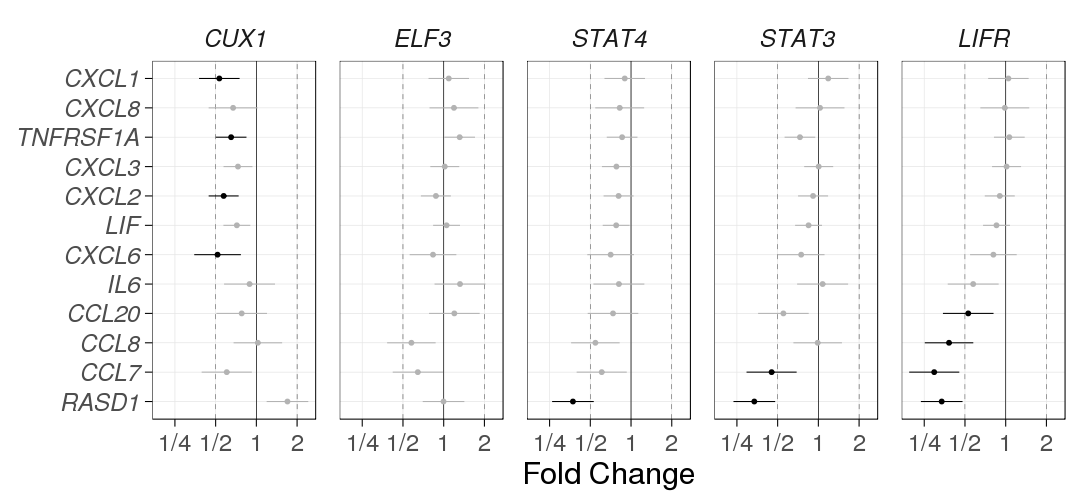

In [28]:
these_genes <- c(
  "IL6", "RASD1", "CCL7", "CCL8", "CCL20", "CXCL8",
  "LIF", "TNFRSF1A", "CXCL1", "CXCL2", "CXCL3", "CXCL6"
)

options(repr.plot.width = 9, repr.plot.height = length(these_genes) * 0.35)

dat_errorbar <- sirna$fit1_top %>%
filter(Coef %in% sirnas) %>%
filter(ID %in% c(these_genes)) %>%
dplyr::select(Coef, ID, logFC, CI.L, CI.R, adj.P.Val) %>%
reshape2::melt(id.vars = c("ID", "Coef")) %>%
reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value")

this_offset <- abs(min(dat_errorbar$logFC))

dat_errorbar <- dat_errorbar %>%
mutate(logFC = logFC + this_offset) %>%
seriate_cols("Coef", "ID", value.var = "logFC", method = "PCA") %>%
mutate(logFC = logFC - this_offset)

p <- ggplot() +
geom_vline(xintercept = 0, size = 0.2) +
geom_vline(xintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
geom_errorbarh(
  data = dat_errorbar,
  mapping = aes(y = ID, xmin = CI.L, xmax = CI.R, color = adj.P.Val < 0.05),
  height = 0,
  size = 0.3
) +
geom_point(
  data = dat_errorbar,
  mapping = aes(y = ID, x = logFC, color = adj.P.Val < 0.05),
  size = 1
) +
scale_color_manual(values = c(
  "TRUE" = "black",
  "FALSE" = "grey70"
)) +
scale_x_continuous(
  labels = function(x) fractional(2^x),
  breaks = scales::pretty_breaks(3)
) +
facet_grid(~ Coef) +
labs(x = bquote("Fold Change"), y = NULL) +
theme(
  plot.title = element_text(size = 20),
  legend.position = "none",
  panel.grid.major = element_line(size = 0.2, color = "grey90"),
  panel.spacing = unit(1, "lines"),
  axis.text.y = element_text(face = "italic"),
  strip.text = element_text(face = "italic")
)

show_plot(p)

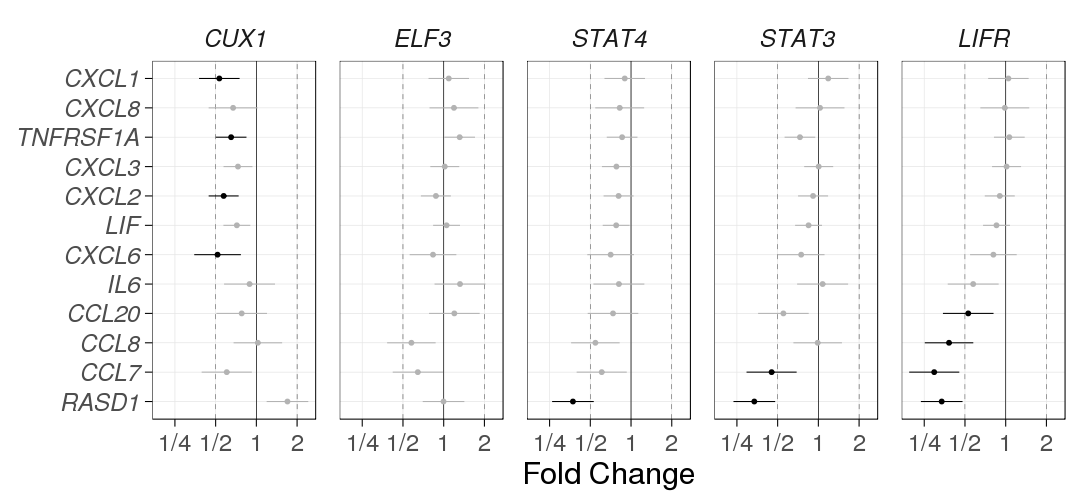

In [29]:
these_genes <- c(
  "IL6", "RASD1", "CCL7", "CCL8", "CCL20", "CXCL8",
  "LIF", "TNFRSF1A", "CXCL1", "CXCL2", "CXCL3", "CXCL6"
)

options(repr.plot.width = 9, repr.plot.height = length(these_genes) * 0.35)

dat_errorbar <- sirna$fit1_top %>%
filter(Coef %in% sirnas) %>%
filter(ID %in% c(these_genes)) %>%
dplyr::select(Coef, ID, logFC, CI.L, CI.R, adj.P.Val) %>%
reshape2::melt(id.vars = c("ID", "Coef")) %>%
reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value")

this_offset <- abs(min(dat_errorbar$logFC))

dat_errorbar <- dat_errorbar %>%
mutate(logFC = logFC + this_offset) %>%
seriate_cols("Coef", "ID", value.var = "logFC", method = "PCA") %>%
mutate(logFC = logFC - this_offset)

p <- ggplot() +
geom_vline(xintercept = 0, size = 0.2) +
geom_vline(xintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
geom_errorbarh(
  data = dat_errorbar,
  mapping = aes(y = ID, xmin = CI.L, xmax = CI.R, color = adj.P.Val < 0.05),
  height = 0,
  size = 0.3
) +
geom_point(
  data = dat_errorbar,
  mapping = aes(y = ID, x = logFC, color = adj.P.Val < 0.05),
  size = 1
) +
scale_color_manual(values = c(
  "TRUE" = "black",
  "FALSE" = "grey70"
)) +
scale_x_continuous(
  labels = function(x) fractional(2^x),
  breaks = scales::pretty_breaks(3)
) +
facet_grid(~ Coef) +
labs(x = bquote("Fold Change"), y = NULL) +
theme(
  plot.title = element_text(size = 20),
  legend.position = "none",
  panel.grid.major = element_line(size = 0.2, color = "grey90"),
  panel.spacing = unit(1, "lines"),
  axis.text.y = element_text(face = "italic"),
  strip.text = element_text(face = "italic")
)

show_plot(p)

### Gene set enrichment

In [30]:
sirna$hmark <- rbindlist(parallel::mclapply(
  mc.cores = 10,
  X = colnames(sirna$des1),
  FUN = function(contrast) {
    retval <- limma::camera(
      y        = sirna$log2tpm_batch,
      design   = sirna$des1,
      contrast = which(colnames(sirna$des1) == contrast),
      index    = ids2indices(
        gene.sets    = MSIGDB_H_ENSEMBL,
        identifiers  = rownames(sirna$log2tpm_batch),
        remove.empty = TRUE
      )
    )
    retval$contrast <- contrast
    retval$set      <- rownames(retval)
    retval$log10p   <- -log10(retval$PValue) * ifelse(retval$Direction == "Up", 1, -1)
    return(retval[order(rownames(retval)),])
  }
))

head(sirna$hmark)

sirna$hmark %>%
group_by(contrast) %>%
summarise(n = sum(PValue < 0.005 / nrow(sirna$hmark)))

NGenes,Direction,PValue,FDR,contrast,set,log10p
199,Up,2.333284e-23,1.666632e-22,d0t0,HALLMARK_ADIPOGENESIS,22.632032
193,Up,2.056430e-02,2.284922e-02,d0t0,HALLMARK_ALLOGRAFT_REJECTION,1.686886
101,Up,1.793171e-12,4.269454e-12,d0t0,HALLMARK_ANDROGEN_RESPONSE,11.746378
36,Up,5.514130e-03,6.411779e-03,d0t0,HALLMARK_ANGIOGENESIS,2.258523
200,Up,2.900079e-06,4.264822e-06,d0t0,HALLMARK_APICAL_JUNCTION,5.537590
44,Up,3.611823e-02,3.925895e-02,d0t0,HALLMARK_APICAL_SURFACE,1.442274


contrast,n
CUX1,8
d0t0,37
d0t1,38
d0t16,36
d0t6,38
d1t1,38
d1t16,36
d1t6,38
ELF3,7
LIFR,13


[1] 4.69897

[1] 16

NGenes,Direction,PValue,FDR,contrast,set,log10p,signif
101,Up,2.135097e-07,2.135097e-06,CUX1,HALLMARK_ANDROGEN_RESPONSE,6.670582,TRUE
200,Up,2.117690e-03,4.603675e-03,CUX1,HALLMARK_APICAL_JUNCTION,2.674138,FALSE
74,Up,1.672012e-05,9.288956e-05,CUX1,HALLMARK_CHOLESTEROL_HOMEOSTASIS,4.776761,TRUE
200,Up,5.279070e-08,6.598837e-07,CUX1,HALLMARK_E2F_TARGETS,7.277443,TRUE
198,Up,3.226574e-06,2.304696e-05,CUX1,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,5.491258,TRUE
200,Up,6.711755e-09,1.118626e-07,CUX1,HALLMARK_G2M_CHECKPOINT,8.173164,TRUE


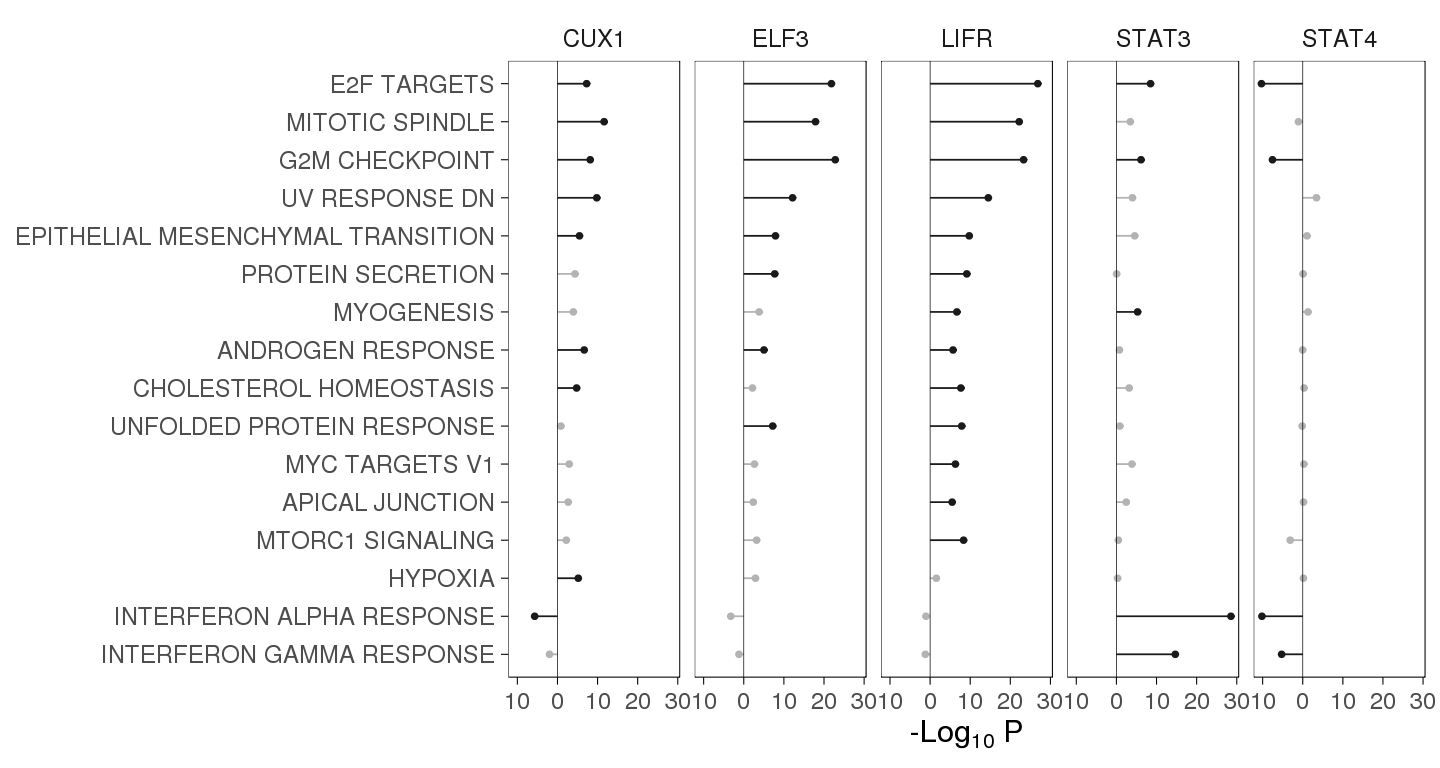

In [31]:
sirna$hmark_dat <- subset(sirna$hmark, contrast %in% c(sirnas))

sirna$hmark_dat_bonf <- -log10(0.005 / nrow(sirna$hmark_dat))
# sirna$hmark_dat_bonf <- -log10(0.00000005 / nrow(sirna$hmark_dat))
sirna$hmark_dat_bonf

sirna$hmark_dat <- sirna$hmark_dat %>%
group_by(contrast) %>%
mutate(signif = abs(log10p) > sirna$hmark_dat_bonf) %>%
group_by(set) %>%
filter(sum(signif) >= 1)

length(unique(sirna$hmark_dat$set))

options(repr.plot.width = 12, repr.plot.height = length(unique(sirna$hmark_dat$set)) * 0.4)

head(sirna$hmark_dat)

sirna$hmark_dat$set <- factor(sirna$hmark_dat$set)
sirna$hmark_dat$set <- reorder(sirna$hmark_dat$set, sirna$hmark_dat$log10p)

p <- ggplot(sirna$hmark_dat, aes(y = set, x = log10p, color = signif)) +
geom_point() +
geom_segment(mapping = aes(yend = set, xend = 0)) +
geom_vline(xintercept = 0, size = 0.2) +
scale_color_manual(values = c("TRUE" = "grey10", "FALSE" = "grey70")) +
scale_x_continuous(labels = abs) +
scale_y_discrete(
  labels = function(x) str_replace_all(substr(x, 10, 100), "_", " ")
) +
facet_grid(~ contrast) +
labs(y = NULL, x = bquote("-Log"[10]~"P")) +
theme(legend.position = "none")

show_plot(p)

In [32]:
print(unname(gene_symbols[intersect(
  MSIGDB_H_ENSEMBL[["HALLMARK_INTERFERON_ALPHA_RESPONSE"]],
  rownames(sirna$log2tpm)
)]))

 [1] "MX1"      "ISG15"    "OAS1"     "IFIT3"    "IFI44"    "IFI35"   
 [7] "IRF7"     "RSAD2"    "IFI44L"   "IFITM1"   "IFI27"    "IRF9"    
[13] "OASL"     "EIF2AK2"  "IFIT2"    "CXCL10"   "TAP1"     "SP110"   
[19] "DDX60"    "UBE2L6"   "USP18"    "PSMB8"    "IFIH1"    "BST2"    
[25] "LGALS3BP" "ADAR"     "ISG20"    "GBP2"     "IRF1"     "PLSCR1"  
[31] "HERC6"    "SAMD9"    "CMPK2"    "IFITM3"   "RTP4"     "STAT2"   
[37] "SAMD9L"   "LY6E"     "IFITM2"   "HELZ2"    "CXCL11"   "TRIM21"  
[43] "PARP14"   "TRIM26"   "PARP12"   "NMI"      "RNF31"    "HLA-C"   
[49] "CASP1"    "TRIM14"   "TDRD7"    "DHX58"    "PARP9"    "PNPT1"   
[55] "TRIM25"   "PSME1"    "WARS"     "EPSTI1"   "UBA7"     "PSME2"   
[61] "B2M"      "TRIM5"    "C1S"      "LAP3"     "LAMP3"    "GBP4"    
[67] "NCOA7"    "TMEM140"  "CD74"     "GMPR"     "PSMA3"    "PROCR"   
[73] "IL7"      "IFI30"    "IRF2"     "CSF1"     "IL15"     "CNP"     
[79] "FAM46A"   "IL4R"     "CMTR1"    "CD47"     "LPAR6"    "MOV10"   
[85] "

In [33]:
sirna$meta[1:5,]

sample,donor,sirna,time,stimulation,timefactor,dosefactor,TEMP,TEMP2,TEMP3,dosetime,sirnatime,sirna_dose,time2
000008520469_A01,RA5,Ctrl,0,None,0,0,TNF (1) + IL17 (1),-0.25,1,d0t0,Ctrlt0,Ctrl_0,0
000008520469_B01,RA5,Ctrl,0,None,0,0,TNF (1) + IL17 (1),0.30,1,d0t0,Ctrlt0,Ctrl_0,0
000008520469_C01,RA5,Ctrl,1,TNF (1),1,0,TNF (1),1.60,1,d0t1,Ctrlt1,Ctrl_0,1
000008520469_D01,RA5,Ctrl,1,TNF (1) + IL17 (1),1,1,TNF (1) + IL17 (1),2.00,1,d1t1,Ctrlt1,Ctrl_1,1
000008520469_E01,RA5,Ctrl,6,TNF (1),6,0,TNF (1),3.60,1,d0t6,Ctrlt6,Ctrl_0,36


In [34]:
with(sirna$meta, table(time, stimulation))

    stimulation
time None TNF (1) TNF (1) + IL17 (1)
  0    48       0                  0
  1     0      24                 24
  6     0      24                 24
  16    0      24                 24

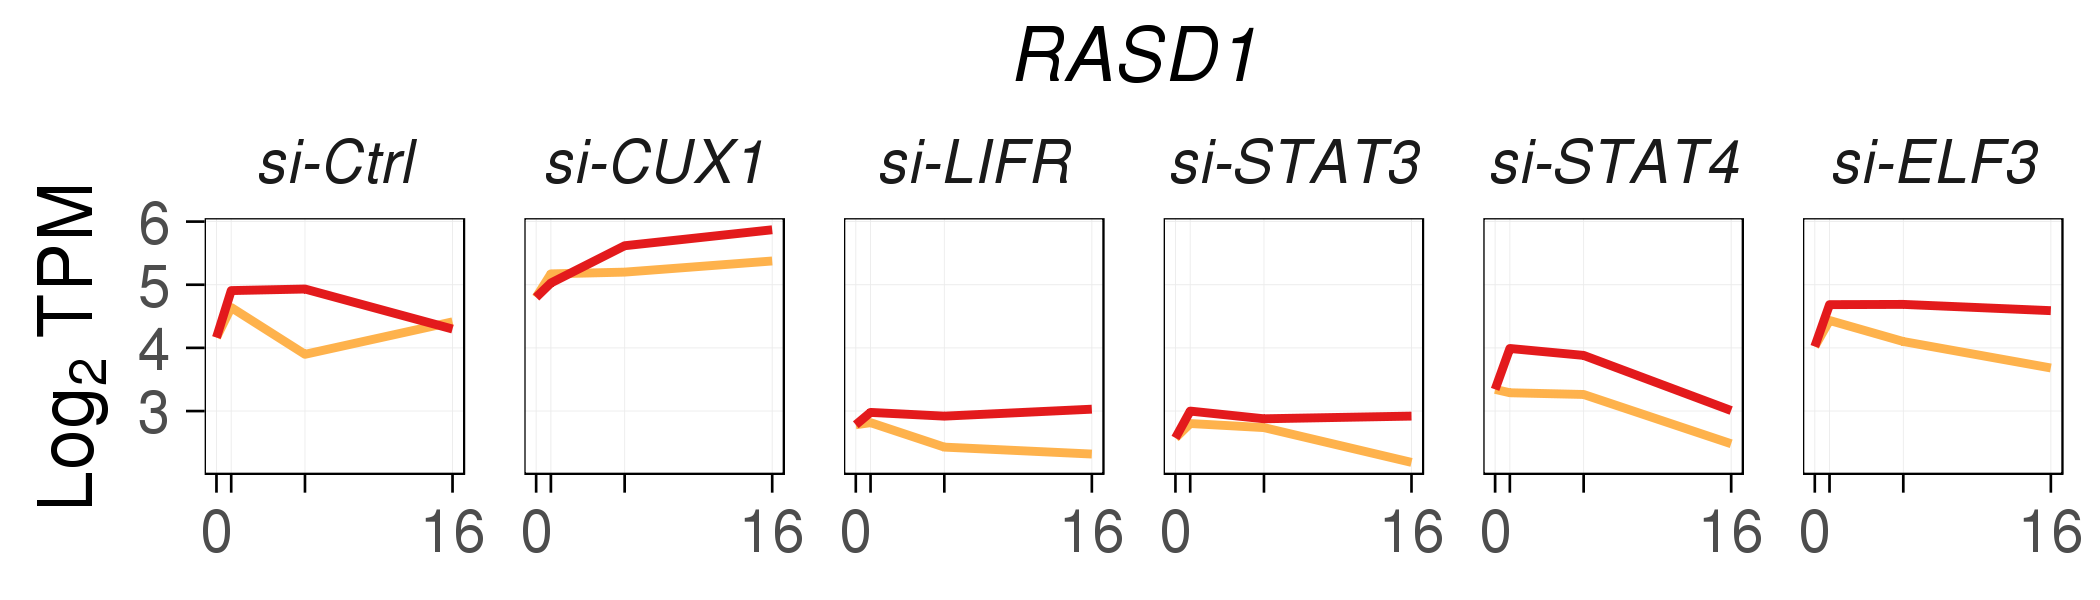

In [128]:
plot_sirna_gene <- function(this_gene) {
  # this_gene <- "RASD1"
  this_ensembl <- names(which(gene_symbols == this_gene))
  # this_ensembl

  p_dat      <- sirna$meta_zero
  p_dat$gene <- as.numeric(sirna$log2tpm_zero[this_ensembl,])

  p_dat <- p_dat %>%
  # group_by(timefactor, dosefactor, sirna) %>%
  group_by(time, dosefactor, sirna) %>%
  summarise(gene = median(gene))

  p_dat$sirna <- factor(
    sprintf("si-%s", as.character(p_dat$sirna)),
    c("si-Ctrl", "si-CUX1", "si-LIFR", "si-STAT3", "si-STAT4", "si-ELF3")
  )
  
#   p_dat$sirna <- sprintf("si-%s", p_dat$sirna)

  # options(repr.plot.width = 7, repr.plot.height = 2)

  p <- ggplot() +
  geom_line(
    data = p_dat,
    mapping = aes(x = time, y = gene, group = dosefactor, color = dosefactor),
    size = 1
  ) +
  # facet_wrap(~ dosefactor) +
  facet_grid(~ sirna) +
  scale_x_continuous(
    breaks = c(0, 1, 6, 16),
    labels = c(0, "", "", 16)
  ) +
  scale_y_continuous(
    breaks = pretty_breaks(3)
  ) +
  # scale_color_manual(values = meta_colors$sirna) +
  scale_color_manual(values = c(
    "0" = '#FEB24C',
    "1" = '#E31A1C'
  )) +
  labs(x = NULL, y = bquote("Log"[2]~"TPM"), title = this_gene) +
  theme(
    title = element_text(face = "italic"),
    panel.grid.major = element_line(size = 0.1),
    panel.spacing.x = unit(1, "lines"),
    strip.text = element_text(face = "italic"),
    legend.position = "none"
  )
}

# # my_genes <- c("CXCL1", "CXCL2", "CXCL3", "IL6", "CXCL8", "CCL20", "LIF")
# plots <- lapply(my_genes, plot_sirna_gene)

# options(repr.plot.width = 7, repr.plot.height = 2 * length(my_genes))

# show_plot(patchwork::wrap_plots(plots, nrow = length(my_genes)))

options(repr.plot.width = 7, repr.plot.height = 2)

p <- plot_sirna_gene("RASD1")
show_plot(p, res = 300)

### LIFR

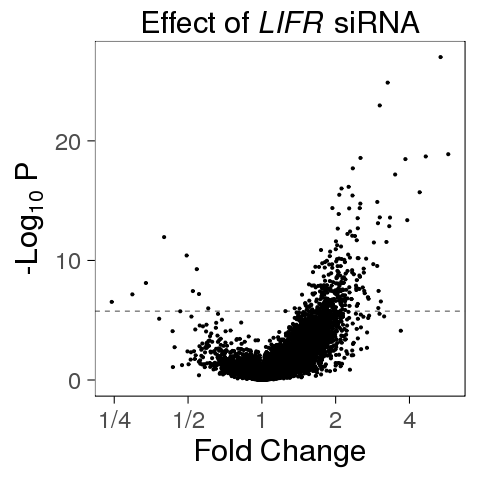

In [36]:
options(repr.plot.width = 4, repr.plot.height = 4)

d_LIFR <- topTable(sirna$fit1, coef = "LIFR", number = 1e6)

p <- ggplot() +
geom_point(
  data = d_LIFR,
  mapping = aes(x = logFC, y = -log10(P.Value)),
  size = 0.5
) +
# geom_text_repel(
#   data = d_LIFR %>% filter(logFC < 0 & adj.P.Val < 1e-11),
#   mapping = aes(logFC, -log10(P.Value), label = ID),
#   fontface = "italic"
# ) +
# geom_point(
#   data = d_LIFR %>% filter(logFC < 0 & adj.P.Val < 1e-11),
#   mapping = aes(logFC, -log10(P.Value)),
#   color = "red", size = 1
# ) +
# geom_text_repel(
#   data = d_LIFR %>% filter(logFC > 0 & adj.P.Val < 1e-24),
#   mapping = aes(logFC, -log10(P.Value), label = ID),
#   fontface = "italic"
# ) +
# geom_point(
#   data = d_LIFR %>% filter(logFC > 0 & adj.P.Val < 1e-24),
#   mapping = aes(logFC, -log10(P.Value)),
#   color = "red", size = 1
# ) +
geom_hline(
  yintercept = -log10(0.05 / nrow(sirna$fit1$coefficients)),
  linetype = 2,
  size = 0.2
) +
scale_x_continuous(labels = function(x) fractional(2^x)) +
labs(
  x = "Fold Change",
  y = bquote("-Log"[10]~"P"),
#   title = "Effect of LIFR siRNA"
  title = expression(paste("Effect of ", italic("LIFR"), " siRNA"))
)
show_plot(p)

In [37]:
d_LIFR$ensembl_id <- rownames(d_LIFR)
readr::write_tsv(x = d_LIFR %>% filter(adj.P.Val < 0.05), path = "share/effect-of-LIFR-sirna.tsv")

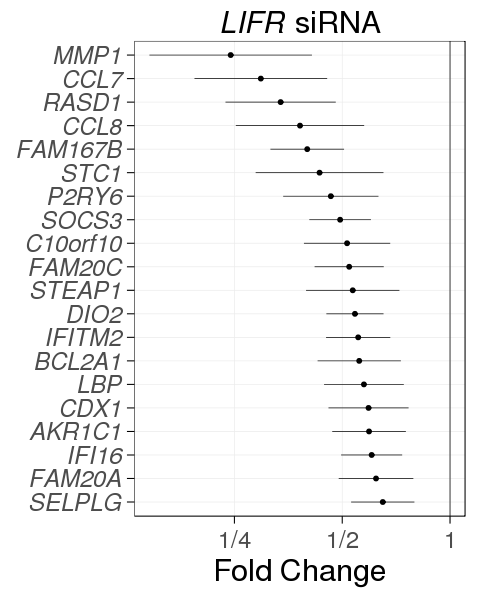

In [38]:
options(repr.plot.width = 4, repr.plot.height = 5)

p <- topTable(sirna$fit1, coef = "LIFR", number = 1e3, confint = TRUE) %>%
filter(logFC < 0) %>%
top_n(n = 20, wt = abs(logFC)) %>%
ggplot(aes(x = logFC, y = reorder(ID, -logFC), xmin = CI.L, xmax = CI.R)) +
geom_vline(xintercept = 0, size = 0.2) +
geom_point(size = 1) +
geom_errorbarh(height = 0, size = 0.2) +
scale_x_continuous(labels = function(x) fractional(2^x)) +
labs(
  x = "Fold Change",
  y = NULL,
#   title = "Effect of LIFR siRNA"
  title = expression(paste(italic("LIFR"), " siRNA"))
) +
theme(axis.text.y = element_text(face = "italic"), panel.grid.major = element_line(size = 0.2))
show_plot(p)

Estimate the effect of exposure to IL-17:

## siRNA and IL-17 interaction

There are some weak effects, but it is hard to summarize them.

In [39]:
clean_cols <- function(x) {
  colnames(x) <- str_replace_all(colnames(x), "[()]", "")
  colnames(x) <- str_replace_all(colnames(x), ":", "")
  colnames(x) <- str_replace_all(colnames(x), regex("DoseFactor", ignore_case = TRUE), "d")
  colnames(x) <- str_replace_all(colnames(x), "DoseExposure", "d")
  colnames(x) <- str_replace_all(colnames(x), "TimeFactor", "t")
  colnames(x) <- str_replace_all(colnames(x), "TRUE", "1")
  colnames(x) <- str_replace_all(colnames(x), "sirna", "")
  colnames(x) <- str_replace_all(colnames(x), "dosetime", "")
  colnames(x) <- str_replace_all(colnames(x), "\\^", "_")
  return(x)
}
sirna$des2 <- clean_cols(with(
  sirna$meta,
  model.matrix(~ 0 + time + time2 + sirna:dosefactor)
))
# sirna$fit2 <- lmFit(object = sirna$log2tpm_batch, design = sirna$des2)
sirna$fit2 <- lmFit(object = sirna$log2tpm, design = sirna$des2)
sirna$fit2 <- eBayes(sirna$fit2)
sirna$fit2$genes <- gene_symbols[rownames(sirna$fit2$coefficients)]

print(colnames(sirna$des2))

topTable(sirna$fit2, coef = "CUX1d1")

 [1] "time"    "time2"   "Ctrld0"  "CUX1d0"  "ELF3d0"  "LIFRd0"  "STAT3d0"
 [8] "STAT4d0" "Ctrld1"  "CUX1d1"  "ELF3d1"  "LIFRd1"  "STAT3d1" "STAT4d1"


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000080824,HSP90AA1,8.680673,8.711705,108.09213,3.346943e-165,9.668650e-161,366.0202
ENSG00000166710,B2M,12.354926,12.775884,104.44839,1.425719e-162,2.059309e-158,360.1740
ENSG00000113732,ATP6V0E1,9.001944,9.111144,102.70705,2.767827e-161,2.665233e-157,357.3044
ENSG00000167996,FTH1,13.707379,14.217282,96.27949,2.435578e-156,1.758975e-152,346.2575
ENSG00000026025,VIM,12.445271,12.360596,95.38486,1.258614e-155,7.271769e-152,344.6599
ENSG00000106333,PCOLCE,9.386679,9.378592,89.66835,6.535811e-151,3.146775e-147,334.0758
ENSG00000156508,EEF1A1,12.697203,12.774820,86.78309,2.021664e-148,8.343119e-145,328.4708
ENSG00000101608,MYL12A,9.485007,9.582396,82.80673,7.420999e-145,2.679723e-141,320.4312
ENSG00000105404,RABAC1,8.556348,8.580783,81.63944,8.868354e-144,2.846545e-140,317.9978
ENSG00000187109,NAP1L1,8.797143,8.654270,78.58157,6.932421e-141,2.002638e-137,311.4555


In [40]:
sirna$con_dose <- limma::contrasts.fit(
  fit = sirna$fit2,
  contrasts = makeContrasts(
    contrasts = c(
      "(CUX1d1 - CUX1d0) - (Ctrld1 - Ctrld0)",
      "(LIFRd1 - LIFRd0) - (Ctrld1 - Ctrld0)",
      "(ELF3d1 - ELF3d0) - (Ctrld1 - Ctrld0)",
      "(STAT3d1 - STAT3d0) - (Ctrld1 - Ctrld0)"
    ),
    levels = sirna$des2
  )
)
sirna$con_dose <- eBayes(sirna$con_dose)
sirna$con_dose$genes <- gene_symbols[rownames(sirna$con_dose$p.value)]
print(colnames(sirna$con_dose$p.value))

topTable(sirna$con_dose, coef = 2)

[1] "(CUX1d1 - CUX1d0) - (Ctrld1 - Ctrld0)"  
[2] "(LIFRd1 - LIFRd0) - (Ctrld1 - Ctrld0)"  
[3] "(ELF3d1 - ELF3d0) - (Ctrld1 - Ctrld0)"  
[4] "(STAT3d1 - STAT3d0) - (Ctrld1 - Ctrld0)"


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000176812,AC112778.1,-0.2297066,0.01435666,-5.068919,9.906666e-07,0.02861838,-0.8693554
ENSG00000217805,AL590084.1,-0.6090730,0.04353215,-4.611309,7.585022e-06,0.10955806,-1.4870119
ENSG00000236565,HNRNPA3P5,0.5593384,0.07325845,4.218393,3.899781e-05,0.37552290,-1.9870254
ENSG00000057663,ATG5,1.2824391,5.17289749,4.109219,6.031231e-05,0.43557552,-2.1205108
ENSG00000243516,RPL12P40,0.3556000,0.03121575,3.599399,4.125471e-04,0.64219489,-2.7096815
ENSG00000163312,HELQ,1.0550708,3.35180704,3.568237,4.611293e-04,0.64219489,-2.7437724
ENSG00000218107,AL136131.1,-0.2126235,0.01952506,-3.500441,5.860264e-04,0.64219489,-2.8171407
ENSG00000250678,AC008629.2,0.2546139,0.01799195,3.495373,5.965382e-04,0.64219489,-2.8225810
ENSG00000215002,RPL23AP59,0.4577366,0.05029473,3.493914,5.995979e-04,0.64219489,-2.8241465
ENSG00000213780,GTF2H4,1.1906314,2.38491752,3.457244,6.814863e-04,0.64219489,-2.8633113


### Try splines...

In [41]:
library(splines)

In [42]:
clean_cols <- function(x) {
  colnames(x) <- str_replace_all(colnames(x), "[()]", "")
  colnames(x) <- str_replace_all(colnames(x), ":", "")
  colnames(x) <- str_replace_all(colnames(x), regex("DoseFactor", ignore_case = TRUE), "d")
  colnames(x) <- str_replace_all(colnames(x), "DoseExposure", "d")
  colnames(x) <- str_replace_all(colnames(x), "TimeFactor", "t")
  colnames(x) <- str_replace_all(colnames(x), "TRUE", "1")
  colnames(x) <- str_replace_all(colnames(x), "sirna", "")
  colnames(x) <- str_replace_all(colnames(x), "_dose", "")
  colnames(x) <- str_replace_all(colnames(x), "dosetime", "")
  colnames(x) <- str_replace_all(colnames(x), "\\^", "")
  return(x)
}
sirna$des3 <- clean_cols(with(
  sirna$meta,
  model.matrix(~ 0 + bs(time, df = 3, intercept = FALSE) + sirna_dose)
))
colnames(sirna$des3)[1:3] <- sprintf("bs%s", 1:3)
# sirna$des3 <- sirna$des3[,!(colnames(sirna$des3) %in% c("Ctrl_1"))]
sirna$fit3 <- lmFit(object = sirna$log2tpm_batch, design = sirna$des3)
sirna$fit3 <- eBayes(sirna$fit3)
sirna$fit3$genes <- gene_symbols[rownames(sirna$fit3$coefficients)]

print(colnames(sirna$des3))

# topTable(sirna$fit3, coef = "CUX1_0", confint = TRUE)

# these_coefs <- c(paste(sirnas, "0", sep = "_"), paste(sirnas, "1", sep = "_"))

# sirna$fit3_top <- rbindlist(lapply(these_coefs, function(this_coef) {
#   retval <- topTable(sirna$fit3, coef = this_coef, confint = TRUE, number = 1e6)
#   retval$Coef <- this_coef
#   retval
# }))

# sirna$fit3_top %>% filter(ID %in% c("CXCL1"))

sirna$con_dose <- limma::contrasts.fit(
  fit = sirna$fit3,
  contrasts = makeContrasts(
    contrasts = c(
      sprintf("%s_0 - Ctrl_0", sirnas),
      sprintf("%s_1 - Ctrl_1", sirnas)
    ),
    levels = sirna$des3
  )
)
sirna$con_dose <- eBayes(sirna$con_dose)
sirna$con_dose$genes <- gene_symbols[rownames(sirna$con_dose$p.value)]
print(colnames(sirna$con_dose$p.value))

sirna$con_dose_top <- rbindlist(lapply(seq(ncol(sirna$con_dose$coefficients)), function(i) {
  this_col <- str_split_fixed(colnames(sirna$con_dose$contrasts), " ", 2)[,1][i]
  retval <- topTable(sirna$con_dose, coef = i, confint = TRUE, number = 1e6)
  retval$ensembl_id <- rownames(retval)
  retval$Coef <- this_col
  retval
}))

#topTable(sirna$con_dose, coef = 1, number = 1e6) %>% filter(ID %in% c("CSF3", "CXCL1"))
                                
# sirna$con_dose_top %>% filter(ID %in% c("CSF3", "CXCL1"))
sirna$con_dose_top %>% filter(ID %in% c("CXCL1")) %>% arrange(Coef)
sirna$con_dose_top %>% filter(ID %in% c("CSF3")) %>% arrange(Coef)
sirna$con_dose_top %>% filter(ID %in% c("CCL8")) %>% arrange(Coef)

 [1] "bs1"     "bs2"     "bs3"     "Ctrl_0"  "Ctrl_1"  "CUX1_0"  "CUX1_1" 
 [8] "ELF3_0"  "ELF3_1"  "LIFR_0"  "LIFR_1"  "STAT3_0" "STAT3_1" "STAT4_0"
[15] "STAT4_1"
 [1] "CUX1_0 - Ctrl_0"  "ELF3_0 - Ctrl_0"  "LIFR_0 - Ctrl_0"  "STAT3_0 - Ctrl_0"
 [5] "STAT4_0 - Ctrl_0" "CUX1_1 - Ctrl_1"  "ELF3_1 - Ctrl_1"  "LIFR_1 - Ctrl_1" 
 [9] "STAT3_1 - Ctrl_1" "STAT4_1 - Ctrl_1"


ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef
CXCL1,-1.1190164,-1.78028330,-0.4577494,6.764179,-3.3393605,0.001022358,0.0625718,-1.007356,ENSG00000163739,CUX1_0
CXCL1,-0.5600327,-1.41372468,0.2936592,6.764179,-1.2945413,0.197151274,0.4794836,-5.412530,ENSG00000163739,CUX1_1
CXCL1,-0.1780428,-0.83930972,0.4832242,6.764179,-0.5313139,0.595862014,0.9214315,-6.018929,ENSG00000163739,ELF3_0
CXCL1,0.6282534,-0.22543860,1.4819453,6.764179,1.4522364,0.148192017,0.3781442,-5.197728,ENSG00000163739,ELF3_1
CXCL1,-0.1431283,-0.80439520,0.5181387,6.764179,-0.4271223,0.669805185,0.9428907,-6.119468,ENSG00000163739,LIFR_0
CXCL1,0.4159089,-0.43778310,1.2696008,6.764179,0.9613924,0.337655914,0.6089092,-5.826478,ENSG00000163739,LIFR_1
CXCL1,-0.1773083,-0.83857527,0.4839586,6.764179,-0.5291222,0.597378280,0.9488501,-6.062796,ENSG00000163739,STAT3_0
CXCL1,0.9416533,0.08796132,1.7953452,6.764179,2.1766746,0.030818474,0.2245924,-3.939157,ENSG00000163739,STAT3_1
CXCL1,-0.3359237,-0.99719061,0.3253433,6.764179,-1.0024610,0.317478509,0.7503727,-5.763585,ENSG00000163739,STAT4_0
CXCL1,0.1475563,-0.70613569,1.0012482,6.764179,0.3410831,0.733442338,0.9925854,-6.075730,ENSG00000163739,STAT4_1


ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef
CSF3,-0.04808592,-0.3557375,0.25956570,0.3238616,-0.3084341,0.7581118018,0.99979336,-6.1894225,ENSG00000108342,CUX1_0
CSF3,-0.42609127,-0.8232678,-0.02891474,0.3238616,-2.1170092,0.0356449810,0.17274152,-4.0804749,ENSG00000108342,CUX1_1
CSF3,0.10771843,-0.1999332,0.41537005,0.3238616,0.6909307,0.4905069547,0.87177094,-5.9253815,ENSG00000108342,ELF3_0
CSF3,-0.10250559,-0.4996821,0.29467095,0.3238616,-0.5092929,0.6111761677,0.86180668,-6.0848040,ENSG00000108342,ELF3_1
CSF3,-0.04355108,-0.3512027,0.26410054,0.3238616,-0.2793466,0.7803023686,0.98356640,-6.1698347,ENSG00000108342,LIFR_0
CSF3,-0.60651233,-1.0036889,-0.20933579,0.3238616,-3.0134205,0.0029591114,0.02761569,-1.9792737,ENSG00000108342,LIFR_1
CSF3,-0.04853714,-0.3561888,0.25911449,0.3238616,-0.3113283,0.7559144746,0.99308148,-6.1510028,ENSG00000108342,STAT3_0
CSF3,-0.67853481,-1.0757113,-0.28135827,0.3238616,-3.3712599,0.0009173183,0.03110269,-0.8865945,ENSG00000108342,STAT3_1
CSF3,-0.04848853,-0.3561402,0.25916309,0.3238616,-0.3110166,0.7561510679,0.96933103,-6.2021118,ENSG00000108342,STAT4_0
CSF3,-0.34496234,-0.7421389,0.05221420,0.3238616,-1.7139249,0.0882790447,0.38402182,-4.7348729,ENSG00000108342,STAT4_1


ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef
CCL8,-0.1923395,-0.7566880,0.37200887,4.191738,-0.6725506,5.021032e-01,9.239003e-01,-6.0168535,ENSG00000108700,CUX1_0
CCL8,0.4177565,-0.3108142,1.14632717,4.191738,1.1315017,2.593624e-01,5.583150e-01,-5.6020402,ENSG00000108700,CUX1_1
CCL8,-0.9021239,-1.4664723,-0.33777548,4.191738,-3.1544421,1.887356e-03,7.982713e-02,-1.5068022,ENSG00000108700,ELF3_0
CCL8,-0.6113454,-1.3399161,0.11722523,4.191738,-1.6558412,9.951157e-02,2.953550e-01,-4.8963956,ENSG00000108700,ELF3_1
CCL8,-1.5665960,-2.1309445,-1.00224762,4.191738,-5.4778911,1.447020e-07,5.500199e-05,7.1400187,ENSG00000108700,LIFR_0
CCL8,-1.1000260,-1.8285967,-0.37145531,4.191738,-2.9794420,3.290103e-03,2.943852e-02,-2.0731938,ENSG00000108700,LIFR_1
CCL8,-0.2502843,-0.8146327,0.31406415,4.191738,-0.8751650,3.826607e-01,8.742725e-01,-5.8290828,ENSG00000108700,STAT3_0
CCL8,0.3718424,-0.3567282,1.10041312,4.191738,1.0071426,3.152301e-01,7.045060e-01,-5.7051261,ENSG00000108700,STAT3_1
CCL8,-1.0192266,-1.5835750,-0.45487817,4.191738,-3.5639132,4.688513e-04,2.487604e-02,-0.3131267,ENSG00000108700,STAT4_0
CCL8,-0.6350884,-1.3636591,0.09348226,4.191738,-1.7201495,8.713901e-02,3.822736e-01,-4.7247970,ENSG00000108700,STAT4_1


### This is the best model!

In [43]:
# clean_cols <- function(x) {
#   colnames(x) <- str_replace_all(colnames(x), "[()]", "")
#   colnames(x) <- str_replace_all(colnames(x), ":", "")
#   colnames(x) <- str_replace_all(colnames(x), regex("DoseFactor", ignore_case = TRUE), "d")
#   colnames(x) <- str_replace_all(colnames(x), "DoseExposure", "d")
#   colnames(x) <- str_replace_all(colnames(x), "TimeFactor", "t")
#   colnames(x) <- str_replace_all(colnames(x), "TRUE", "1")
#   colnames(x) <- str_replace_all(colnames(x), "sirna", "")
#   colnames(x) <- str_replace_all(colnames(x), "_dose", "")
#   colnames(x) <- str_replace_all(colnames(x), "dosetime", "")
#   colnames(x) <- str_replace_all(colnames(x), "\\^", "")
#   return(x)
# }
# ix_nozero <- 1:nrow(sirna$meta)
# # ix_nozero <- which(sirna$meta$time > 0)
# sirna$meta$time2 <- sirna$meta$time ^ 2
# sirna$meta$time3 <- sirna$meta$time ^ 3
# sirna$des3 <- clean_cols(with(
#   sirna$meta[ix_nozero,],
#   # This model works well when you exclude time point 0
# #   model.matrix(~ 0 + time:dosefactor + time2:dosefactor + sirna_dose)
#   # This model yields a better fit for genes like CXCL1
#   model.matrix(~ 0 + time:dosefactor + time2:dosefactor + time3 + sirna_dose)
# ))
# # sirna$des3 <- sirna$des3[,!(colnames(sirna$des3) %in% c("Ctrl_1"))]
# sirna$fit3 <- lmFit(object = sirna$log2tpm_batch[,ix_nozero], design = sirna$des3)
# sirna$fit3 <- eBayes(sirna$fit3)
# sirna$fit3$genes <- gene_symbols[rownames(sirna$fit3$coefficients)]

# print(colnames(sirna$des3))

# # topTable(sirna$fit3, coef = "CUX1_0", confint = TRUE)

# these_coefs <- c(paste(sirnas, "0", sep = "_"), paste(sirnas, "1", sep = "_"))

# sirna$fit3_top <- rbindlist(lapply(these_coefs, function(this_coef) {
#   retval <- topTable(sirna$fit3, coef = this_coef, confint = TRUE, number = 1e6)
#   retval$ensembl_id <- rownames(retval)
#   retval$Coef <- this_coef
#   retval
# }))

# sirna$fit3_top %>% filter(ID %in% c("CXCL1")) %>% arrange(ID, Coef)

# sirna$con_dose <- limma::contrasts.fit(
#   fit = sirna$fit3,
#   contrasts = makeContrasts(
#     contrasts = c(
#       sprintf("%s_0 - Ctrl_0", sirnas),
#       sprintf("%s_1 - Ctrl_1", sirnas)
#     ),
#     levels = sirna$des3
#   )
# )
# sirna$con_dose <- eBayes(sirna$con_dose)
# sirna$con_dose$genes <- gene_symbols[rownames(sirna$con_dose$p.value)]
# print(colnames(sirna$con_dose$p.value))

# sirna$con_dose_top <- rbindlist(lapply(seq(ncol(sirna$con_dose$coefficients)), function(i) {
#   this_col <- str_split_fixed(colnames(sirna$con_dose$contrasts), " ", 2)[,1][i]
#   retval <- topTable(sirna$con_dose, coef = i, confint = TRUE, number = 1e6)
#   retval$ensembl_id <- rownames(retval)
#   retval$Coef <- this_col
#   retval
# }))

# #topTable(sirna$con_dose, coef = 1, number = 1e6) %>% filter(ID %in% c("CSF3", "CXCL1"))
                                
# # sirna$con_dose_top %>% filter(ID %in% c("CSF3", "CXCL1"))
# sirna$con_dose_top %>% filter(ID %in% c("CXCL1")) %>% arrange(Coef)
# sirna$con_dose_top %>% filter(ID %in% c("CSF3")) %>% arrange(Coef)
# sirna$con_dose_top %>% filter(ID %in% c("CCL7")) %>% arrange(Coef)

In [44]:
# my_contrasts <- sprintf("%s_0 + %s_1 - Ctrl_0 - Ctrl_1", sirnas, sirnas)

# sirna$con_dose <- limma::contrasts.fit(
#   fit = sirna$fit3,
#   contrasts = makeContrasts(
#     contrasts = my_contrasts,
#     levels = sirna$des3
#   )
# )
# sirna$con_dose <- eBayes(sirna$con_dose)
# sirna$con_dose$genes <- gene_symbols[rownames(sirna$con_dose$p.value)]
# print(colnames(sirna$con_dose$p.value))

# sirna$con_dose_top <- rbindlist(lapply(seq(ncol(sirna$con_dose$coefficients)), function(i) {
#   this_col <- str_split_fixed(colnames(sirna$con_dose$contrasts), " ", 2)[,1][i]
#   retval <- topTable(sirna$con_dose, coef = i, confint = TRUE, number = 1e6)
#   retval$Coef <- this_col
#   retval
# }))

# #topTable(sirna$con_dose, coef = 1, number = 1e6) %>% filter(ID %in% c("CSF3", "CXCL1"))
                                
# # sirna$con_dose_top %>% filter(ID %in% c("CSF3", "CXCL1"))
# sirna$con_dose_top %>% filter(ID %in% c("CXCL1")) %>% arrange(Coef)
# sirna$con_dose_top %>% filter(ID %in% c("CSF3")) %>% arrange(Coef)
# sirna$con_dose_top %>% filter(ID %in% c("CCL8")) %>% arrange(Coef)

In [45]:
# None of these contrasts have strong results

# sirna$con_dose <- limma::contrasts.fit(
#   fit = sirna$fit3,
#   contrasts = makeContrasts(
#     contrasts = c(
#       "CUX1_1 - CUX1_0",
#       "LIFR_1 - LIFR_0",
#       "ELF3_1 - ELF3_0",
#       "STAT3_1 - STAT3_0",
#       "STAT4_1 - STAT4_0"
#     ),
#     levels = sirna$des3
#   )
# )
# sirna$con_dose <- eBayes(sirna$con_dose)
# sirna$con_dose$genes <- gene_symbols[rownames(sirna$con_dose$p.value)]
# print(colnames(sirna$con_dose$p.value))

# topTable(sirna$con_dose, coef = 4)

In [80]:
# these_genes <- c(
#   "CSF3", "IL6", "RASD1", "CCL7", "CCL8", "CCL20", "CXCL8",
#   "LIF", "TNFRSF1A", "CXCL1", "CXCL2", "CXCL3", "CXCL6"
# )

plot_sirna_effects <- function(these_genes, only_signif = FALSE) {

  dat_errorbar <- sirna$con_dose_top %>%
  # filter(Coef %in% sirnas) %>%
  filter(ID %in% c(these_genes)) %>%
  dplyr::select(Coef, ID, logFC, CI.L, CI.R, adj.P.Val) %>%
  reshape2::melt(id.vars = c("ID", "Coef")) %>%
  reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value") %>%
  mutate(FC = 2 ^ logFC)
  
  dat_errorbar %<>%
  mutate(signif = adj.P.Val < 0.05)
  
  if (only_signif) {
    signif_genes <- unique((dat_errorbar %>%
    group_by(ID) %>%
    filter(sum(signif) > 0))$ID)
    dat_errorbar %<>%
    filter(ID %in% signif_genes)
  }
  
  
  dat_errorbar %<>%
  seriate_cols("Coef", "ID", value.var = "FC")

  dat_errorbar <- dat_errorbar %>% tidyr::separate(Coef, c("sirna", "dose"))

  # head(dat_errorbar)
  dat_errorbar %>% filter(ID == "CXCL8") %>%
  mutate(FC = 2 ^ logFC)
  
  options(repr.plot.width = 9, repr.plot.height = 1 + length(unique(dat_errorbar$ID)) * 0.25)
  
  ggplot() +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    data = dat_errorbar,
    mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, alpha = signif, group = dose),
    width = 0,
    size = 0.3,
    position = position_dodge(width = 0.75)
  ) +
  geom_point(
    data = dat_errorbar,
    mapping = aes(x = ID, y = logFC, alpha = signif, fill = dose, group = dose),
    position = position_dodge(width = 0.75),
    shape = 21, size = 2
  ) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "TRUE" = 1,
      "FALSE" = 0.33
    )
  ) +
  scale_color_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "0" = "white",
      "1" = "black"
    )
#     values = c(
#       "TRUE" = "black",
#       "FALSE" = "grey60"
#     )
  ) +
  scale_fill_manual(
    name = "IL-17",
    values = c(
      "0" = "white",
      "1" = "black"
    ),
    labels = c(
      "0" = "none",
      "1" = "1 ng/mL"
    )
  ) +
#   geom_vline(
#     xintercept = seq(length(these_genes)) + 0.5,
#     size = 0.2, color = "grey90"
#   ) +
  guides(fill = guide_legend(override.aes = list(size = 3))) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(3)
  ) +
  facet_grid(~ sirna) +
  labs(y = bquote("Fold Change"), x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20),
    legend.position = "right",
    panel.grid.major = element_line(size = 0.2, color = "grey90"),
    panel.spacing = unit(1, "lines"),
    axis.text.y = element_text(face = "italic"),
    strip.text = element_text(face = "italic")
  )
}

# these_genes <- (dat %>% filter(category == 1))$ID
# plot_sirna_effects(these_genes, TRUE) %>% show_plot

# these_genes <- (dat %>% filter(category == 2))$ID
# plot_sirna_effects(these_genes, TRUE)

# these_genes <- (dat %>%
# filter(category == 3) %>%
# arrange(-t10) %>%
# dplyr::select(-Intercept, -t2, -t4, -t6) %>% head(20))$ID
# plot_sirna_effects(these_genes, TRUE)

## siRNA effect sizes

In [81]:
colnames(sirna$con_dose$coefficients)

NULL

Summarise the effects of TNF, IL-17, and siRNAs:

In [83]:
log2tpm_batch <- removeBatchEffect(x = log2tpm, batch = m$donor, batch2 = m$Plate)
# log2tpm_zero <- log2tpm_batch[,as.character(meta_zero$Sample)]

clean_cols <- function(x) {
  colnames(x) <- str_replace_all(colnames(x), "[()]", "")
  colnames(x) <- str_replace_all(colnames(x), ":", "")
  colnames(x) <- str_replace_all(colnames(x), "DoseFactor", "d")
  colnames(x) <- str_replace_all(colnames(x), "DoseExposure", "d")
  colnames(x) <- str_replace_all(colnames(x), "TimeFactor", "t")
  colnames(x) <- str_replace_all(colnames(x), "TRUE", "1")
  return(x)
}
des_e <- clean_cols(with(
  m,
  model.matrix(~ 0 + TimeFactor + DoseExposure)
))
fit_e <- lmFit(object = log2tpm_batch, design = des_e)
fit_e <- eBayes(fit_e)
fit_e$genes <- gene_symbols[rownames(fit_e$coefficients)]

topTable(fit_e, coef = "d1")

print(colnames(fit_e$coefficients))

con_e <- limma::contrasts.fit(
  fit = fit_e,
  contrasts = makeContrasts(
    contrasts = c(
      "t6 - t0"
    ),
    levels = des_e
  )
)
con_e <- eBayes(con_e)
con_e$genes <- gene_symbols[rownames(con_e$p.value)]

dat_tnf <- topTable(con_e, number = 1e6)
dat_tnf <- dat_tnf[order(rownames(dat_tnf)),]
dat_tnf$coef <- "TNF"

dat_il17 <- topTable(fit_e, coef = "d1", number = 1e6)
dat_il17 <- dat_il17[order(rownames(dat_il17)),]
dat_il17$coef <- "TNF+IL17"

options(repr.plot.width = 5, repr.plot.height = 4)

# plot(dat_tnf$logFC, dat_il17$logFC)

#topTable(fit_e, coef = "t24", number = 1e6)

head(dat_tnf)

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000163874,ZC3H12A,2.309863,4.774003,32.82768,1.135466e-74,3.125256e-70,152.53055
ENSG00000163739,CXCL1,4.114187,10.331480,29.15833,2.341731e-67,3.222690e-63,137.50933
ENSG00000081041,CXCL2,4.114947,6.595709,28.44022,7.489846e-66,6.871684e-62,134.37844
ENSG00000163734,CXCL3,4.002224,7.853183,28.00757,6.213844e-65,4.275746e-61,132.46049
ENSG00000144802,NFKBIZ,2.083548,5.618601,21.74779,1.502201e-50,8.269318e-47,101.89507
ENSG00000136244,IL6,2.792838,10.748031,21.69532,2.024044e-50,9.284963e-47,101.61581
ENSG00000166920,C15orf48,3.270225,5.677772,21.48175,6.836914e-50,2.688275e-46,100.47509
ENSG00000169429,CXCL8,1.568106,11.640560,19.13113,6.551864e-44,2.254169e-40,87.49836
ENSG00000164400,CSF2,2.364865,3.957780,16.40941,1.238547e-36,3.787752e-33,71.56133
ENSG00000168389,MFSD2A,1.584620,3.738421,15.43326,6.036238e-34,1.661414e-30,65.63930


 [1] "t0"  "t2"  "t4"  "t6"  "t8"  "t10" "t12" "t18" "t24" "d1" 


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,coef
ENSG00000000003,TSPAN6,-0.02168844,4.8621108,-0.1806214,0.856884141,0.98863672,-6.792585,TNF
ENSG00000000419,DPM1,0.03645551,6.2353408,0.4102873,0.682122017,0.95784533,-6.725179,TNF
ENSG00000000457,SCYL3,-0.03631439,2.0831003,-0.2039771,0.838620229,0.98575433,-6.788122,TNF
ENSG00000000460,C1orf112,-0.14339959,2.9196073,-0.6249921,0.532830820,0.89951150,-6.614895,TNF
ENSG00000000938,FGR,0.43399578,0.3640495,2.2601177,0.025108285,0.20793088,-4.308678,TNF
ENSG00000000971,CFH,0.60187760,5.6346698,3.2877006,0.001231954,0.02509868,-1.605811,TNF


In [84]:
sirna$fit1_top %>%
filter(ID == "CXCL3")

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
CXCL3,0.608869678,0.3010429,0.916696429,4.151749,3.90277865,1.339239e-04,2.539745e-04,-1.285502,ENSG00000163734,Intercept,0.655710236,0.81166543,0.529720619
CXCL3,6.746953662,6.3915059,7.102401378,4.151749,37.45311405,2.805309e-87,8.103976e-83,179.695226,ENSG00000163734,d0t1,0.009310319,0.01191146,0.007277197
CXCL3,3.539787591,3.1843399,3.895235307,4.151749,19.64976714,8.548142e-47,3.086734e-43,95.589876,ENSG00000163734,d0t6,0.085984022,0.11000646,0.067207437
CXCL3,2.206016568,1.8505689,2.561464283,4.151749,12.24585113,1.621593e-25,7.097663e-23,47.318418,ENSG00000163734,d0t16,0.216731902,0.27728301,0.169403515
CXCL3,6.948734524,6.5932868,7.304182240,4.151749,38.57322277,2.423711e-89,7.001618e-85,184.940129,ENSG00000163734,d1t1,0.008095105,0.01035674,0.006327353
CXCL3,5.495226618,5.1397789,5.850674334,4.151749,30.50463358,2.505785e-73,2.412904e-69,155.126200,ENSG00000163734,d1t6,0.022170320,0.02836432,0.017328921
CXCL3,4.413394689,4.0579470,4.768842404,4.151749,24.49926039,1.992975e-59,1.439327e-55,123.190366,ENSG00000163734,d1t16,0.046928407,0.06003939,0.036680512
CXCL3,-0.451483901,-0.8069316,-0.096036185,4.151749,-2.50623894,1.308225e-02,1.432057e-01,-3.340509,ENSG00000163734,CUX1,1.367446036,1.74948660,1.068832799
CXCL3,0.025914582,-0.3295331,0.381362298,4.151749,0.14385482,8.857748e-01,9.863841e-01,-6.318666,ENSG00000163734,ELF3,0.982197747,1.25660666,0.767712318
CXCL3,0.021315031,-0.3341327,0.376762747,4.151749,0.11832219,9.059433e-01,9.870966e-01,-6.374305,ENSG00000163734,LIFR,0.985334153,1.26061933,0.770163818


In [85]:
dat_tnf$ensembl_id <- rownames(dat_tnf)
dat_il17$ensembl_id <- rownames(dat_il17)

dat_all <- rbindlist(lapply(sirnas, function(this_sirna) {
  retval <- topTable(sirna$fit1, coef = this_sirna, number = 1e6)
  retval$coef <- this_sirna
  retval$ensembl_id <- rownames(retval)
  retval
}))
#d <- rbindlist(lapply(sirnas, get_sirna_dose))

both_genes <- intersect(unique(dat_all$ID), dat_tnf$ID)

dat_all <- rbindlist(list(
  dat_all[dat_all$ID %in% both_genes,],
  dat_tnf[dat_tnf$ID %in% both_genes,],
  dat_il17[dat_il17$ID %in% both_genes,]
))

table(dat_all$coef)

genes_il17  <- unique(subset(
  dat_all, coef == "TNF+IL17" & logFC > log2(2) & adj.P.Val < 0.05
)$ID)
sprintf("%s TNF+IL17 genes", length(genes_il17))

genes_sirna <- unique(subset(
  dat_all, coef %in% sirnas & logFC < -log2(1.5) & adj.P.Val < 0.05
)$ID)
sprintf("%s sirna genes", length(genes_sirna))

d_genes <- intersect(genes_il17, genes_sirna)
sprintf("%s genes in intersection", length(d_genes))

# Order the genes by the siRNA effects

d_genes <- levels(seriate_cols(
#   d = dat_all %>% filter(ID %in% d_genes & coef %in% sirnas),
  d = dat_all %>%
#     filter(ID %in% d_genes & coef %in% c("CUX1", "LIFR", "TNF+IL17")) %>%
    filter(ID %in% d_genes & coef %in% c("CUX1", "LIFR")) %>%
    mutate(FC = 2^logFC),
  col1 = "ID",
  col2 = "coef",
  value.var = "logFC",
  method = "PCA"
#   method = "PCA"
)$ID)

"CXCL8" %in% genes_sirna
"CCL20" %in% genes_sirna

print(d_genes)


    CUX1     ELF3     LIFR    STAT3    STAT4      TNF TNF+IL17 
   26911    26911    26911    26911    26911    26909    26909 

[1] "35 TNF+IL17 genes"

[1] "394 sirna genes"

[1] "12 genes in intersection"

[1] FALSE

[1] TRUE

 [1] "CXCL1"   "CXCL2"   "CXCL6"   "ADORA2A" "MFSD2A"  "CCL20"   "NAMPT"  
 [8] "NAMPTP1" "CCL7"    "MMP3"    "CCL8"    "STC1"   


In [86]:
sirna$fit1_top[1:5,]

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
HSP90AA1,8.969691,8.861789,9.077593,8.711705,164.0223,4.199370e-199,1.213114e-194,443.7367,ENSG00000080824,Intercept,1.994592e-03,2.149492e-03,1.850854e-03
ATP6V0E1,9.240454,9.125959,9.354948,9.111144,159.2446,8.619467e-197,1.244996e-192,438.6129,ENSG00000113732,Intercept,1.653279e-03,1.789833e-03,1.527144e-03
B2M,12.392492,12.231312,12.553671,12.775884,151.7068,5.326699e-193,5.129256e-189,430.1858,ENSG00000166710,Intercept,1.859895e-04,2.079736e-04,1.663292e-04
FTH1,14.000026,13.810109,14.189944,14.217282,145.4519,1.036956e-189,7.488894e-186,422.8487,ENSG00000167996,Intercept,6.103405e-05,6.962146e-05,5.350585e-05
VIM,12.358288,12.183238,12.533338,12.360596,139.3005,2.450082e-186,1.415559e-182,415.3016,ENSG00000026025,Intercept,1.904516e-04,2.150205e-04,1.686900e-04


In [87]:
# topTable(sirna$fit1, coef = "CUX1", number = 1e6) %>%
# filter(ID %in% genes_il17) %>%
# mutate(FC = 1 / 2^logFC) %>%
# arrange(ID)

In [88]:
# topTable(sirna$con_dose, coef = "CUX1_1 - Ctrl_1", number = 1e6) %>%
# filter(ID %in% genes_il17) %>%
# mutate(FC = 1 / 2^logFC) %>%
# arrange(ID)

In [89]:
"CXCL8" %in% genes_sirna

[1] FALSE

In [90]:
fit1_top <- readr::read_tsv("analysis/limma/002_dose_limma_timefactor_dosefactor.tsv.gz")
head(fit1_top)

fit1_top$ID[fit1_top$ID == "NMES1"] <- "C15orf48"

Parsed with column specification:
cols(
  ID = col_character(),
  logFC = col_double(),
  CI.L = col_double(),
  CI.R = col_double(),
  AveExpr = col_double(),
  t = col_double(),
  P.Value = col_double(),
  adj.P.Val = col_double(),
  B = col_double(),
  ensembl_id = col_character(),
  Coef = col_character(),
  signif = col_logical()
)


ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,signif
GAPDH,12.2361,12.1392,12.3330,11.9755,249.3115,1.073e-216,2.133e-212,449.8856,ENSG00000111640,Intercept,TRUE
TPT1,12.2502,12.1431,12.3573,12.1497,225.8334,1.524e-209,1.515e-205,439.2062,ENSG00000133112,Intercept,TRUE
UBB,10.3344,10.2414,10.4273,10.4976,219.5213,1.707e-207,1.131e-203,436.0108,ENSG00000170315,Intercept,TRUE
SRP14,9.1075,9.0214,9.1936,9.0615,208.7697,7.266e-204,3.611e-200,430.2092,ENSG00000140319,Intercept,TRUE
COX4I1,9.6292,9.5299,9.7285,9.6275,191.4095,1.355e-197,5.386e-194,419.7734,ENSG00000131143,Intercept,TRUE
PPIB,9.9307,9.8237,10.0376,9.8865,183.3484,1.729e-194,5.729e-191,414.4209,ENSG00000166794,Intercept,TRUE


In [56]:
table(fit1_top$Coef)


       d1       d10 Intercept       t10       t12       t18        t2       t24 
    19879     19879     19879     19879     19879     19879     19879     19879 
       t4        t6        t8 
    19879     19879     19879 

In [57]:
d_genes

[1] "CXCL1"   "CXCL2"   "CXCL6"   "ADORA2A" "MFSD2A"  "CCL20"   "NAMPT"  
 [8] "NAMPTP1" "CCL7"    "MMP3"    "CCL8"    "STC1"

In [58]:
"C15orf48" %in% fit1_top$ID
"NMES1" %in% fit1_top$ID

[1] TRUE

[1] FALSE

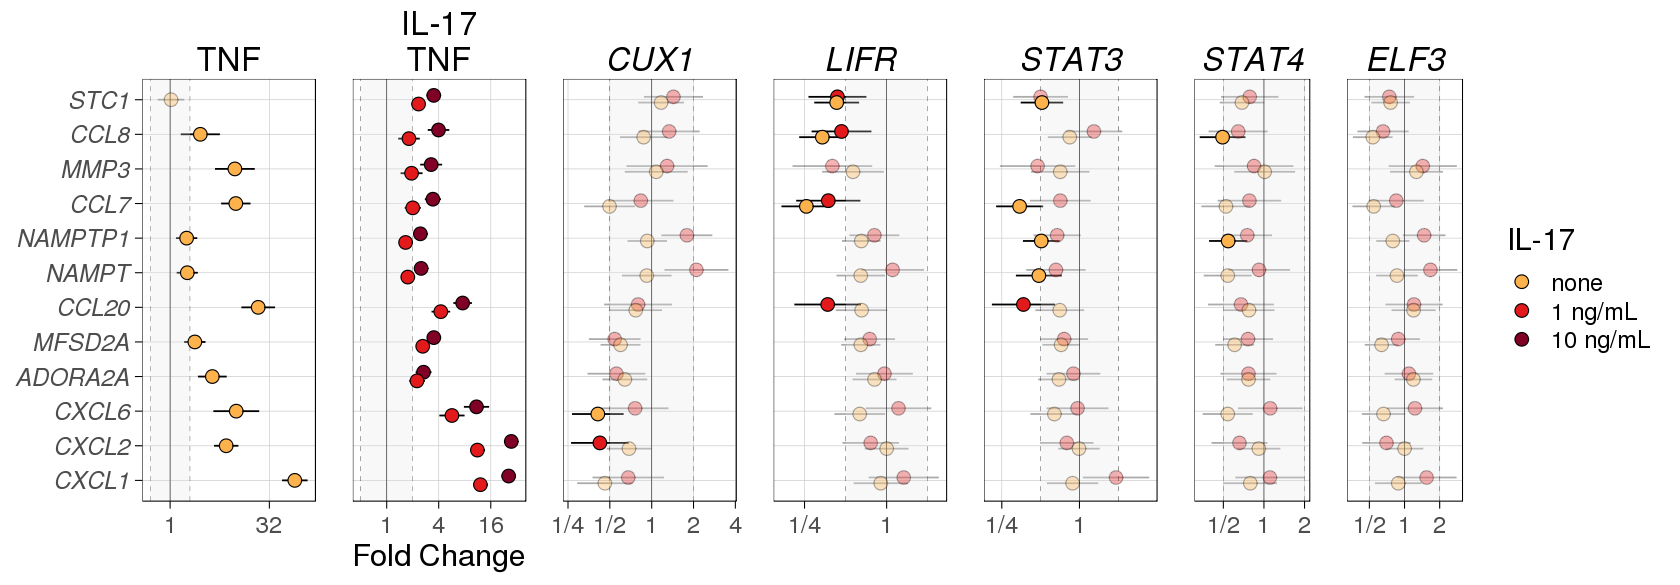

In [59]:
# these_genes <- (dat %>%
# # filter(category == 3) %>%
# arrange(-d10) %>%
# dplyr::select(-Intercept, -t2, -t4, -t6) %>% head)$ID

# these_genes <- c(
#   "IL6", "CXCL8",
# #  "IL11", IL1A", "IL1B",
#   "CSF3", "IL33", "CCL2", "CCL7", "CCL8", "CCL20"
# )

these_genes <- d_genes

p1 <- fit1_top %>%
filter(ID %in% these_genes) %>%
mutate(ID = factor(as.character(ID), these_genes)) %>%
filter(Coef %in% c("t6")) %>%
mutate(signif = adj.P.Val < 0.05) %>%
ggplot() +
coord_flip() +
geom_hline(yintercept = 0, size = 0.2) +
geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
geom_errorbar(
  mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, alpha = signif, group = Coef),
  width = 0,
  size = 0.5,
  position = position_dodge(width = 0.75)
) +
annotate(
  geom = "rect",
  xmin = -Inf, xmax = Inf, ymin = log2(1/2), ymax = log2(2),
  fill = "grey90",
  alpha = 0.25
) +
geom_point(
  mapping = aes(x = ID, y = logFC, alpha = signif, group = Coef),
  position = position_dodge(width = 0.75),
  shape = 21, size = 3.5, fill = meta_colors$Stimulation[["TNF (1)"]], stroke = 0.5
) +
scale_alpha_manual(
  guide = FALSE,
  name = NULL,
  values = c(
    "TRUE" = 1,
    "FALSE" = 0.33
  )
) +
guides(fill = guide_legend(override.aes = list(size = 3.5))) +
scale_y_continuous(
  labels = function(x) fractional(2^x),
  breaks = scales::pretty_breaks(3)
) +
labs(title = "TNF", y = NULL, x = NULL) +
theme(
  legend.title = element_text(size = 18),
  plot.title = element_text(size = 20, hjust = 0.5),
  legend.position = "right",
  panel.grid.major = element_line(size = 0.2, color = "grey80"),
  panel.spacing = unit(1, "lines"),
  axis.text.y = element_text(face = "italic"),
  strip.text = element_text(face = "italic")
)

p2 <- fit1_top %>%
filter(ID %in% these_genes) %>%
mutate(ID = factor(as.character(ID), these_genes)) %>%
filter(Coef %in% c("d1", "d10")) %>%
mutate(signif = adj.P.Val < 0.05) %>%
ggplot() +
coord_flip() +
geom_hline(yintercept = 0, size = 0.2) +
geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
geom_errorbar(
  mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, alpha = signif, group = Coef),
  width = 0,
  size = 0.5,
  position = position_dodge(width = 0.5)
) +
annotate(
  geom = "rect",
  xmin = -Inf, xmax = Inf, ymin = log2(1/2), ymax = log2(2),
  fill = "grey90",
  alpha = 0.25
) +
geom_point(
  mapping = aes(x = ID, y = logFC, alpha = signif, fill = Coef, group = Coef),
  position = position_dodge(width = 0.5),
  shape = 21, size = 3.5, stroke = 0.5
) +
scale_alpha_manual(
  guide = FALSE,
  name = NULL,
  values = c(
    "TRUE" = 1,
    "FALSE" = 0.33
  )
) +
scale_color_manual(
  guide = FALSE,
  name = NULL,
  values = c(
    "d1" = "white",
    "d10" = "black"
  )
) +
scale_fill_manual(
  name = "IL-17",
  values = c(
#     "d1" = "white",
#     "d10" = "black"
    "d1" = meta_colors$Stimulation[["TNF (1) + IL17 (1)"]],
    "d10" = meta_colors$Stimulation[["TNF (1) + IL17 (10)"]]
  ),
  labels = c(
    "d1" = "1 ng/mL",
    "d10" = "10 ng/mL"
  )
) +
guides(fill = guide_legend(override.aes = list(size = 3.5))) +
scale_y_continuous(
  labels = function(x) fractional(2^x),
  breaks = scales::pretty_breaks(3)
) +
labs(title = "IL-17\nTNF", y = bquote("Fold Change"), x = NULL) +
theme(
  legend.position = "none",
  legend.title = element_text(size = 18),
  plot.title = element_text(size = 20, hjust = 0.5),
#   legend.position = "right",
  panel.grid.major = element_line(size = 0.2, color = "grey80"),
  panel.spacing = unit(1, "lines"),
#   axis.text.y = element_text(face = "italic"),
  axis.text.y = element_blank(),
  axis.ticks.y = element_blank(),
  strip.text = element_text(face = "italic")
)

plot_sirna_effects2 <- function(these_genes, this_sirna) {
  sirna$con_dose_top %>%
  dplyr::filter(Coef %in% sprintf(c("%s_0", "%s_1"), this_sirna)) %>%
#   filter(Coef %in% c("LIFR_0", "LIFR_1")) %>%
  dplyr::filter(ID %in% c(these_genes)) %>%
  mutate(ID = factor(as.character(ID), these_genes)) %>%
  dplyr::select(Coef, ID, logFC, CI.L, CI.R, adj.P.Val) %>%
  reshape2::melt(id.vars = c("ID", "Coef")) %>%
  reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value") %>%
  mutate(FC = 2 ^ logFC) %>%
  mutate(signif = adj.P.Val < 0.05) %>%
#   seriate_cols("Coef", "ID", value.var = "FC") %>%
  tidyr::separate(Coef, c("sirna", "dose")) %>%
  mutate(dose = factor(dose, c("0", "1", "10"))) %>%
  ggplot() +
#   facet_grid(~ sirna) +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, alpha = signif, group = dose),
    width = 0,
    size = 0.5,
    position = position_dodge(width = 0.33)
  ) +
  annotate(
    geom = "rect",
    xmin = -Inf, xmax = Inf, ymin = log2(1/2), ymax = log2(2),
    fill = "grey90",
    alpha = 0.25
  ) +
#   geom_segment(
#     mapping = aes(x = ID, xend = ID, y = logFC, yend = 0, alpha = signif, group = dose),
#     position = position_dodge(width = 0.5),
#     size = 1
#   ) +
  geom_point(
    mapping = aes(x = ID, y = logFC, alpha = signif, fill = dose, group = dose),
    position = position_dodge(width = 0.33),
    shape = 21, size = 3.5, stroke = 0.5
  ) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "TRUE" = 1,
      "FALSE" = 0.33
    )
  ) +
  scale_color_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "0" = "white",
      "1" = "black"
    )
  ) +
  scale_fill_manual(
    name = "IL-17",
    values = meta_colors$dosefactor,
#     values = c(
#       "0" = "white",
#       "1" = "black"
#     ),
    breaks = c("0", "1", "10"),
    labels = c(
      "0" = "none",
      "1" = "1 ng/mL",
      "10" = "10 ng/mL"
    ),
    drop = FALSE
  ) +
  guides(fill = guide_legend(override.aes = list(size = 3.5))) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(3)
  ) +
  labs(title = this_sirna, y = NULL, x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20, face = "italic", hjust = 0.5),
    legend.position = "right",
    panel.grid.major = element_line(size = 0.2, color = "grey80"),
    panel.spacing = unit(1, "lines"),
#     axis.text.y = element_text(face = "italic"),
    axis.ticks.y = element_blank(),
    axis.text.y = element_blank(),
    strip.text = element_text(face = "italic")
  )
}

p3 <- plot_sirna_effects2(these_genes, "CUX1") + theme(legend.position = "none")
p4 <- plot_sirna_effects2(these_genes, "LIFR") + theme(legend.position = "none")
p5 <- plot_sirna_effects2(these_genes, "STAT3") + theme(legend.position = "none")
p6 <- plot_sirna_effects2(these_genes, "STAT4") + theme(legend.position = "none")
p7 <- plot_sirna_effects2(these_genes, "ELF3")

# options(repr.plot.width = 9, repr.plot.height = 1 + length(these_genes) * 0.35)
options(repr.plot.width = 14, repr.plot.height = 2 + length(these_genes) * 0.24)

show_plot(
  p1 + p2 + p3 + p4 + p5 + p6 + p7 +
  patchwork::plot_layout(nrow = 1, widths = c(1.5, 1.5, 1.5, 1.5, 1.5, 1, 1))
)

In [70]:
meta_colors$Stimulation

None             TNF (1)  TNF (1) + IL17 (1) TNF (1) + IL17 (10) 
           "grey90"           "#FEB24C"           "#E31A1C"           "#800026"

In [90]:
coef_to_stim <- c("d1" = "TNF (1) + IL17 (1)", "d10" = "TNF (1) + IL17 (10)")
for (x in c("Intercept", "t10", "t12", "t18", "t2", "t24", "t4", "t6", "t8")) {
  coef_to_stim[x] <- "TNF (1)"
}
coef_to_stim

fit1_top$Stimulation <- coef_to_stim[fit1_top$Coef]
head(fit1_top)

d1                   d10             Intercept 
 "TNF (1) + IL17 (1)" "TNF (1) + IL17 (10)"             "TNF (1)" 
                  t10                   t12                   t18 
            "TNF (1)"             "TNF (1)"             "TNF (1)" 
                   t2                   t24                    t4 
            "TNF (1)"             "TNF (1)"             "TNF (1)" 
                   t6                    t8 
            "TNF (1)"             "TNF (1)"

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,signif,Stimulation
GAPDH,12.2361,12.1392,12.3330,11.9755,249.3115,1.073e-216,2.133e-212,449.8856,ENSG00000111640,Intercept,TRUE,TNF (1)
TPT1,12.2502,12.1431,12.3573,12.1497,225.8334,1.524e-209,1.515e-205,439.2062,ENSG00000133112,Intercept,TRUE,TNF (1)
UBB,10.3344,10.2414,10.4273,10.4976,219.5213,1.707e-207,1.131e-203,436.0108,ENSG00000170315,Intercept,TRUE,TNF (1)
SRP14,9.1075,9.0214,9.1936,9.0615,208.7697,7.266e-204,3.611e-200,430.2092,ENSG00000140319,Intercept,TRUE,TNF (1)
COX4I1,9.6292,9.5299,9.7285,9.6275,191.4095,1.355e-197,5.386e-194,419.7734,ENSG00000131143,Intercept,TRUE,TNF (1)
PPIB,9.9307,9.8237,10.0376,9.8865,183.3484,1.729e-194,5.729e-191,414.4209,ENSG00000166794,Intercept,TRUE,TNF (1)


In [58]:
plot_coef <- function(fit1_top, coef = "t6", these_genes = c("RASD1", "CXCL1"), title = "TNF") {
  
#   fill_values <- meta_colors$Stimulation[["TNF (1)"]]
#   if (coef %in% c("d1", "d10")) {
#     fill_values <- meta_colors$Stimulation[["TNF (1)"]]
  
  d <- fit1_top %>%
  filter(ID %in% these_genes) %>%
  mutate(ID = factor(as.character(ID), these_genes)) %>%
  filter(Coef %in% c(coef)) %>%
  mutate(signif = adj.P.Val < 0.05)
  
  ggplot(d) +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, alpha = signif, group = Coef),
    width = 0,
    size = 0.5,
    position = position_dodge(width = 0.75)
  ) +
  annotate(
    geom = "rect",
    ymin = -Inf, ymax = Inf,
    xmin = seq(0.5, length(these_genes) - 0.5, by = 2),
    xmax = seq(0.5, length(these_genes) - 0.5, by = 2) + 1,
    fill = "grey80",
    alpha = 0.25
  ) +
  geom_point(
    mapping = aes(x = ID, y = logFC, alpha = signif, group = Coef, fill = Stimulation),
    position = position_dodge(width = 0.75),
    shape = 21, size = 3.5, stroke = 0.5
  ) +
  scale_fill_manual(values = meta_colors$Stimulation) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "TRUE" = 1,
      "FALSE" = 0.33
    )
  ) +
  guides(fill = guide_legend(override.aes = list(size = 3.5))) +
  scale_x_discrete(expand = c(0, 0)) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(3)
  ) +
  labs(title = title, y = NULL, x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20, hjust = 0.5),
    legend.position = "right",
    panel.grid.major = element_blank(),
    # panel.grid.major = element_line(size = 0.2, color = "grey80"),
    panel.spacing = unit(1, "lines"),
    axis.text.y = element_text(face = "italic", size = 20),
    strip.text = element_text(face = "italic")
  )
}

these_genes <- c("RASD1")
p1 <- plot_coef(fit1_top, coef = "t6", these_genes = these_genes)
p2 <- plot_coef(fit1_top, coef = c("d1", "d10"), title = "IL-17\nTNF", these_genes = these_genes)

p1 + p2

ERROR: Error in eval(lhs, parent, parent): object 'fit1_top' not found


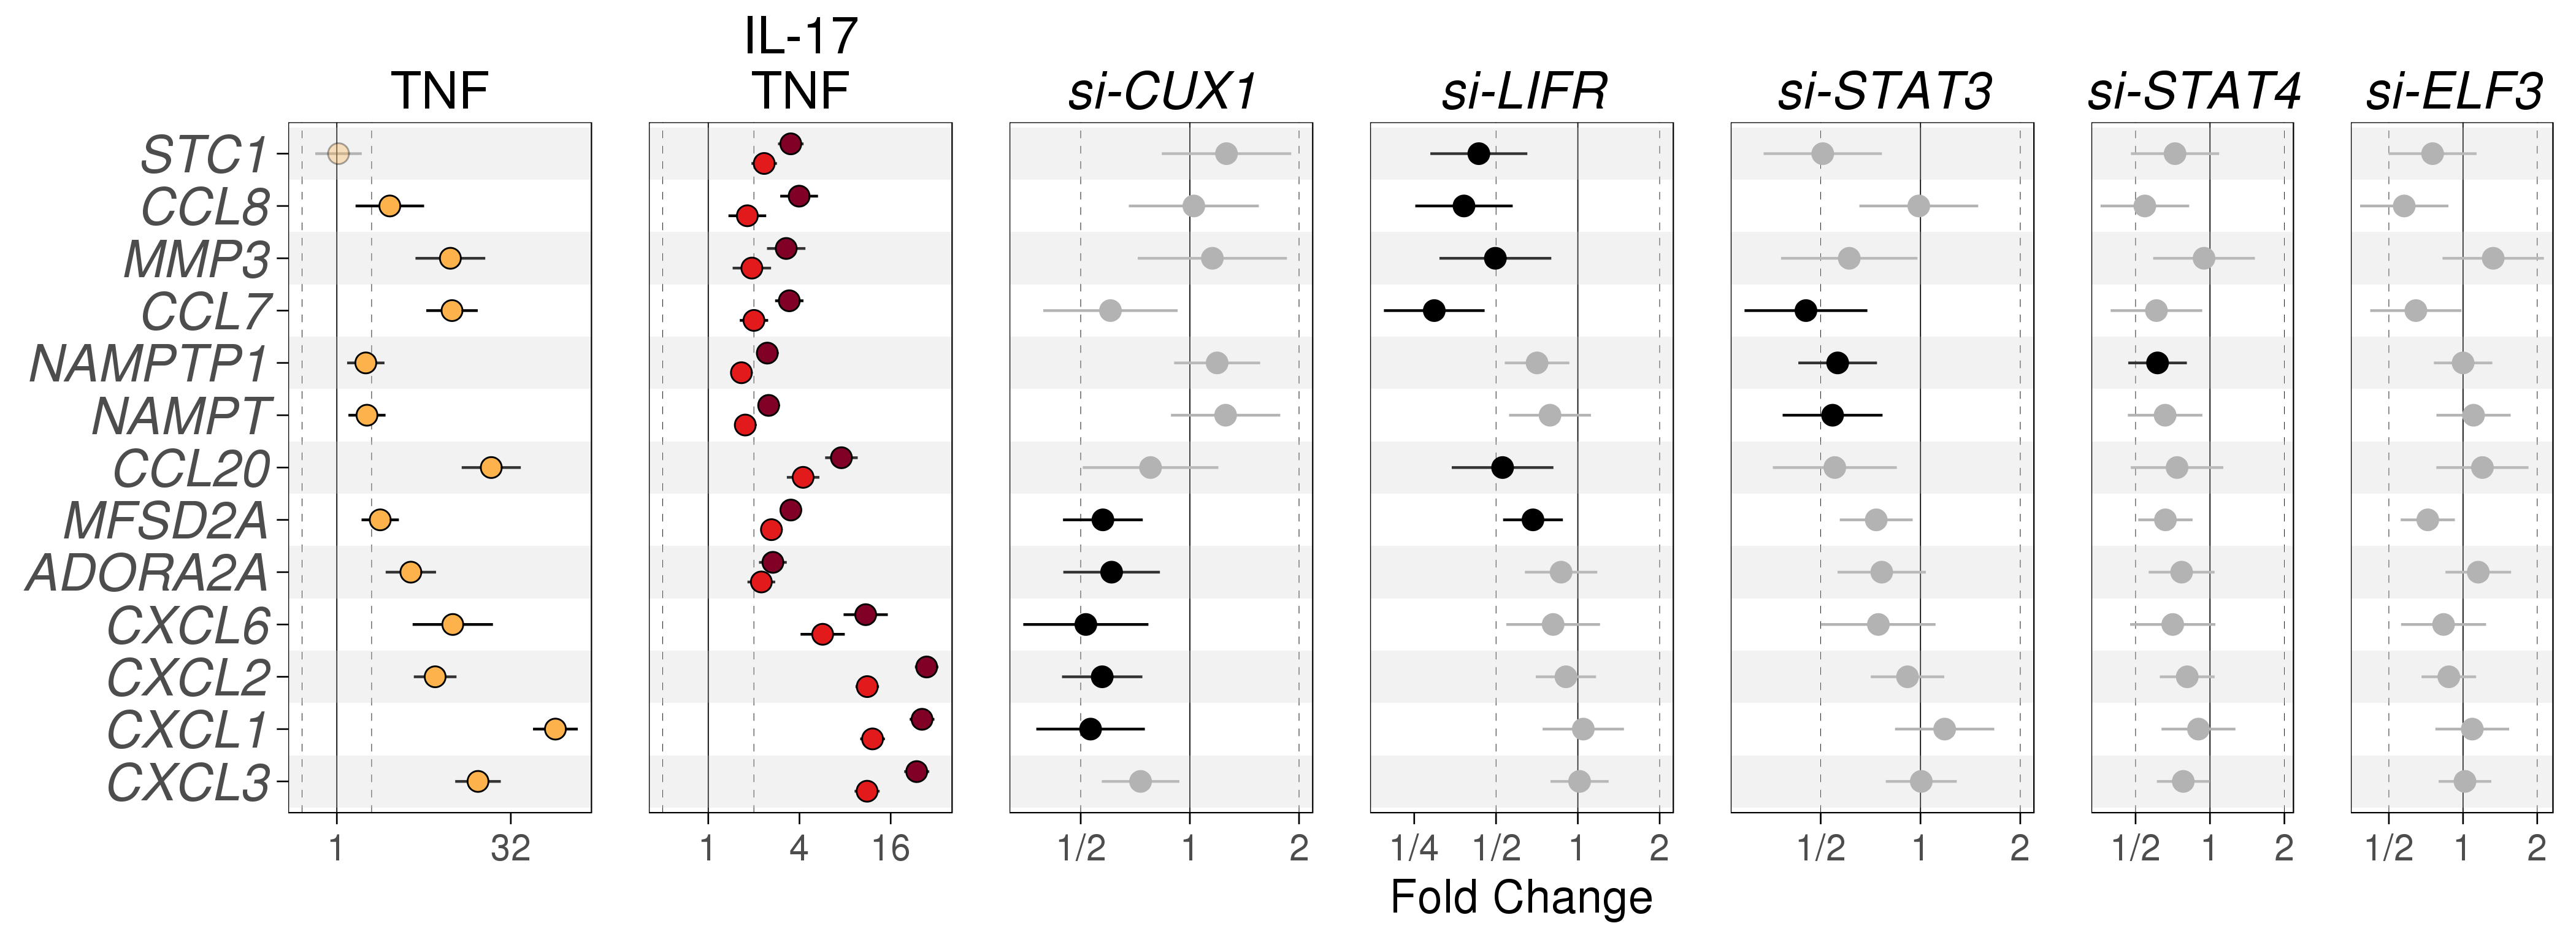

In [120]:
# these_genes <- (dat %>%
# # filter(category == 3) %>%
# arrange(-d10) %>%
# dplyr::select(-Intercept, -t2, -t4, -t6) %>% head)$ID

# these_genes <- c(
#   "IL6", "CXCL8",
# #  "IL11", IL1A", "IL1B",
#   "CSF3", "IL33", "CCL2", "CCL7", "CCL8", "CCL20"
# )

these_genes <- c("CXCL3", d_genes)

p1 <- plot_coef(fit1_top, coef = "t6", these_genes = these_genes) +
  theme(legend.position = "none")

p2 <- plot_coef(fit1_top, coef = c("d1", "d10"), title = "IL-17\nTNF", these_genes = these_genes) +
  theme(
    legend.position = "none",
    axis.ticks.y = element_blank(),
    axis.text.y = element_blank()
  )

plot_sirna_effects3 <- function(these_genes, this_sirna) {
  sirna$fit1_top %>%
  dplyr::filter(Coef %in% this_sirna) %>%
  dplyr::filter(ID %in% c(these_genes)) %>%
  mutate(ID = factor(as.character(ID), these_genes)) %>%
  dplyr::select(Coef, ID, logFC, CI.L, CI.R, adj.P.Val) %>%
  reshape2::melt(id.vars = c("ID", "Coef")) %>%
  reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value") %>%
  mutate(FC = 2 ^ logFC) %>%
  mutate(signif = adj.P.Val < 0.05) %>%
#   tidyr::separate(Coef, c("sirna", "dose")) %>%
#   mutate(dose = factor(dose, c("0", "1", "10"))) %>%
  ggplot() +
#   facet_grid(~ sirna) +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, color = signif),
    width = 0,
    size = 0.5
  ) +
#   annotate(
#     geom = "rect",
#     xmin = -Inf, xmax = Inf, ymin = log2(1/2), ymax = log2(2),
#     fill = "grey90",
#     alpha = 0.25
#   ) +
  annotate(
    geom = "rect",
    ymin = -Inf, ymax = Inf,
    xmin = seq(0.5, length(these_genes) - 0.5, by = 2),
    xmax = seq(0.5, length(these_genes) - 0.5, by = 2) + 1,
    fill = "grey80",
    alpha = 0.25
  ) +
#   geom_segment(
#     mapping = aes(x = ID, xend = ID, y = logFC, yend = 0, color = signif),
#     size = 0.25
#   ) +
  geom_point(
    mapping = aes(x = ID, y = logFC, color = signif),
    size = 3.5, stroke = 0.5
  ) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "TRUE" = 1,
      "FALSE" = 0.33
    )
  ) +
  scale_color_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "FALSE" = "grey70",
      "TRUE" = "black"
    )
  ) +
#   scale_fill_manual(
#     name = "IL-17",
#     values = meta_colors$dosefactor,
# #     values = c(
# #       "0" = "white",
# #       "1" = "black"
# #     ),
#     breaks = c("0", "1", "10"),
#     labels = c(
#       "0" = "none",
#       "1" = "1 ng/mL",
#       "10" = "10 ng/mL"
#     ),
#     drop = FALSE
#   ) +
#   guides(fill = guide_legend(override.aes = list(size = 3.5))) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(3)
  ) +
  labs(title = this_sirna, y = NULL, x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20, face = "italic", hjust = 0.5),
    legend.position = "right",
    panel.grid.major = element_blank(),
    # panel.grid.major = element_line(size = 0.2, color = "grey80"),
    panel.spacing = unit(1, "lines"),
#     axis.text.y = element_text(face = "italic"),
    axis.ticks.y = element_blank(),
    axis.text.y = element_blank(),
    strip.text = element_text(face = "italic")
  )
}

p3 <- plot_sirna_effects3(these_genes, "CUX1") + labs(title = "si-CUX1")
p4 <- plot_sirna_effects3(these_genes, "LIFR") + labs(title = "si-LIFR", y = bquote("Fold Change"))
p5 <- plot_sirna_effects3(these_genes, "STAT3") + labs(title = "si-STAT3")
p6 <- plot_sirna_effects3(these_genes, "STAT4") + labs(title = "si-STAT4")
p7 <- plot_sirna_effects3(these_genes, "ELF3") + labs(title = "si-ELF3")

# options(repr.plot.width = 9, repr.plot.height = 1 + length(these_genes) * 0.35)
options(repr.plot.width = 14, repr.plot.height = 2 + length(these_genes) * 0.24)

show_plot(
  p1 + p2 + p3 + p4 + p5 + p6 + p7 +
  patchwork::plot_layout(nrow = 1, widths = c(1.5, 1.5, 1.5, 1.5, 1.5, 1, 1)),
  res = 300
)

# TNF, TNF+IL17, and siRNA effect sizes

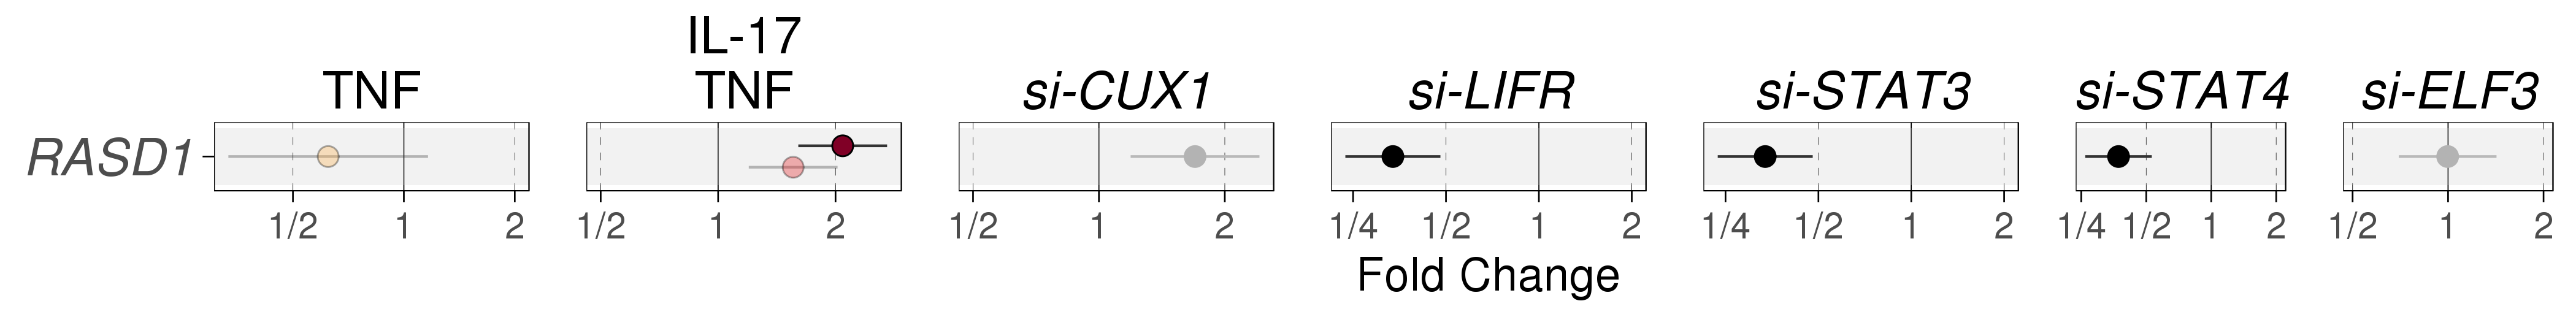

In [125]:
# these_genes <- c("RASD1", "CUX1", "LIFR", "STAT3", "STAT4", "ELF3")

these_genes <- "RASD1"

p1 <- plot_coef(fit1_top, coef = "t6", these_genes = these_genes) +
  theme(legend.position = "none")

p2 <- plot_coef(fit1_top, coef = c("d1", "d10"), title = "IL-17\nTNF", these_genes = these_genes) +
  theme(
    legend.position = "none",
    axis.ticks.y = element_blank(),
    axis.text.y = element_blank()
  )

p3 <- plot_sirna_effects3(these_genes, "CUX1") + labs(title = "si-CUX1")
p4 <- plot_sirna_effects3(these_genes, "LIFR") + labs(title = "si-LIFR", y = bquote("Fold Change"))
p5 <- plot_sirna_effects3(these_genes, "STAT3") + labs(title = "si-STAT3")
p6 <- plot_sirna_effects3(these_genes, "STAT4") + labs(title = "si-STAT4")
p7 <- plot_sirna_effects3(these_genes, "ELF3") + labs(title = "si-ELF3")

# options(repr.plot.width = 9, repr.plot.height = 1 + length(these_genes) * 0.35)
options(repr.plot.width = 14, repr.plot.height = 1.5 + length(these_genes) * 0.24)

show_plot(
  p1 + p2 + p3 + p4 + p5 + p6 + p7 +
  patchwork::plot_layout(nrow = 1, widths = c(1.5, 1.5, 1.5, 1.5, 1.5, 1, 1)),
  res = 300
)

In [129]:
sirnas

[1] "CUX1"  "ELF3"  "LIFR"  "STAT3" "STAT4"

ID,Coef,logFC,CI.L,CI.R,adj.P.Val,FC,signif
RASD1,CUX1,0.763671431,0.2520086,1.2753343,6.574695e-02,1.6978058,FALSE
RASD1,ELF3,-0.004248066,-0.5159109,0.5074148,1.000000e+00,0.9970598,FALSE
RASD1,LIFR,-1.571337868,-2.0830007,-1.0596750,2.251570e-06,0.3364962,TRUE
RASD1,STAT3,-1.572649564,-2.0843124,-1.0609867,3.191212e-06,0.3361904,TRUE
RASD1,STAT4,-1.426421795,-1.9380847,-0.9147589,4.967788e-05,0.3720525,TRUE


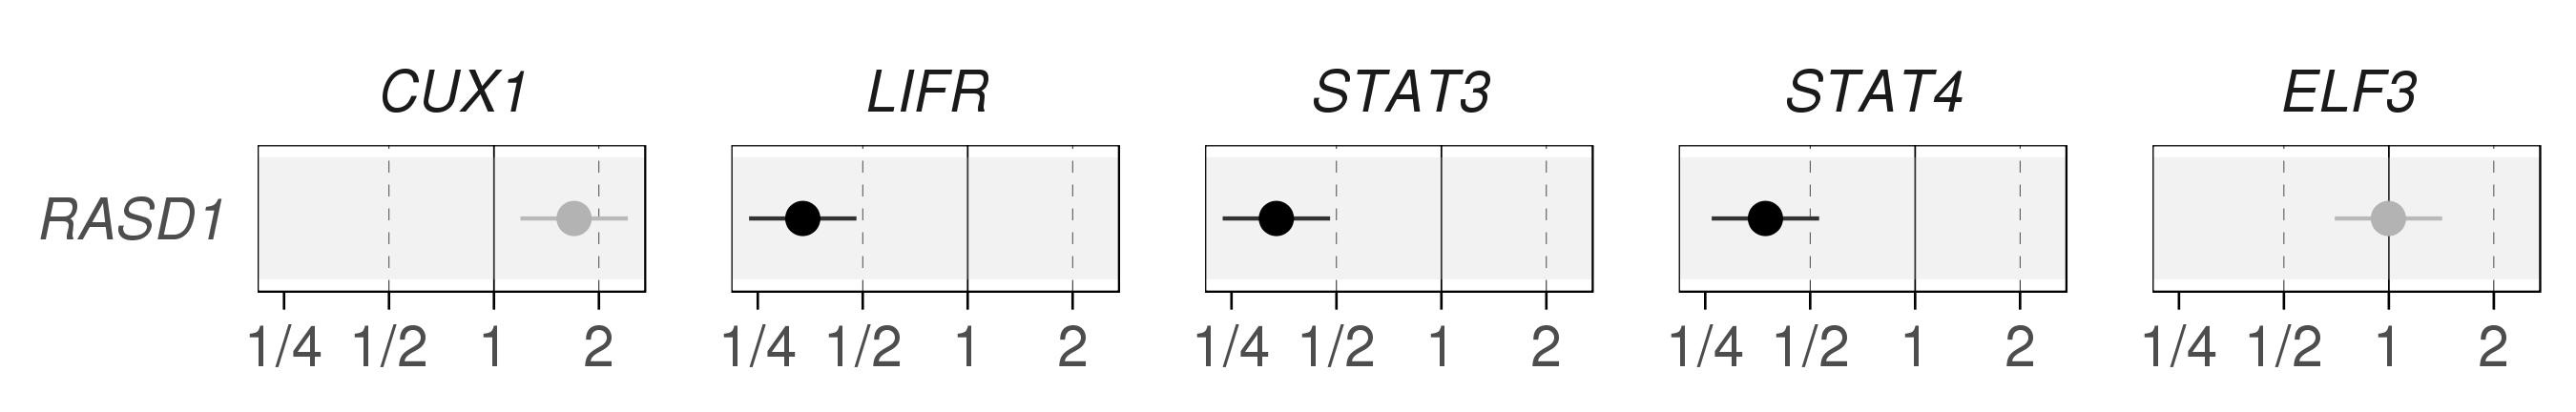

In [146]:
these_genes <- "RASD1"

d <- sirna$fit1_top %>%
  dplyr::filter(Coef %in% sirnas) %>%
  dplyr::filter(ID %in% c(these_genes)) %>%
  mutate(ID = factor(as.character(ID), these_genes)) %>%
  dplyr::select(Coef, ID, logFC, CI.L, CI.R, adj.P.Val) %>%
  reshape2::melt(id.vars = c("ID", "Coef")) %>%
  reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value") %>%
  mutate(FC = 2 ^ logFC) %>%
  mutate(signif = adj.P.Val < 0.05) 
#   tidyr::separate(Coef, c("sirna", "dose")) %>%
#   mutate(dose = factor(dose, c("0", "1", "10"))) %>%

d$Coef <- factor(
  as.character(d$Coef),
  c("CUX1", "LIFR", "STAT3", "STAT4", "ELF3")
)

d

p <-  ggplot(d) +
  facet_grid(~ Coef) +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, color = signif),
    width = 0,
    size = 0.5
  ) +
#   annotate(
#     geom = "rect",
#     xmin = -Inf, xmax = Inf, ymin = log2(1/2), ymax = log2(2),
#     fill = "grey90",
#     alpha = 0.25
#   ) +
  annotate(
    geom = "rect",
    ymin = -Inf, ymax = Inf,
    xmin = seq(0.5, length(these_genes) - 0.5, by = 2),
    xmax = seq(0.5, length(these_genes) - 0.5, by = 2) + 1,
    fill = "grey80",
    alpha = 0.25
  ) +
#   geom_segment(
#     mapping = aes(x = ID, xend = ID, y = logFC, yend = 0, color = signif),
#     size = 0.25
#   ) +
  geom_point(
    mapping = aes(x = ID, y = logFC, color = signif),
    size = 3.5, stroke = 0.5
  ) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "TRUE" = 1,
      "FALSE" = 0.33
    )
  ) +
  scale_color_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "FALSE" = "grey70",
      "TRUE" = "black"
    )
  ) +
#   scale_fill_manual(
#     name = "IL-17",
#     values = meta_colors$dosefactor,
# #     values = c(
# #       "0" = "white",
# #       "1" = "black"
# #     ),
#     breaks = c("0", "1", "10"),
#     labels = c(
#       "0" = "none",
#       "1" = "1 ng/mL",
#       "10" = "10 ng/mL"
#     ),
#     drop = FALSE
#   ) +
#   guides(fill = guide_legend(override.aes = list(size = 3.5))) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(3)
  ) +
  labs(title = NULL, y = NULL, x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20, face = "italic", hjust = 0.5),
    legend.position = "right",
    panel.grid.major = element_blank(),
    # panel.grid.major = element_line(size = 0.2, color = "grey80"),
    panel.spacing = unit(1.5, "lines"),
    axis.text.y = element_text(face = "italic"),
    axis.ticks.y = element_blank(),
#     axis.text.y = element_blank(),
    strip.text = element_text(face = "italic")
  )

options(repr.plot.width = 9, repr.plot.height = 1.2 + length(these_genes) * 0.24)


show_plot(p, res = 300)

In [182]:
d_text <- sirna$fit1_top %>%
    dplyr::filter(Coef %in% sirnas) %>%
    dplyr::filter(ID %in% c(these_genes)) %>%
    mutate(ID = factor(as.character(ID), these_genes)) %>%
    dplyr::select(Coef, ID, logFC, CI.L, CI.R, adj.P.Val) %>%
    reshape2::melt(id.vars = c("ID", "Coef")) %>%
    reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value") %>%
    mutate(FC = 2 ^ logFC) %>%
    mutate(signif = adj.P.Val < 0.05) %>%
    mutate(fc = sprintf(
      "%s%s-fold",
      updown[ifelse(logFC < 0, updown[2], updown[1])],
      signif(2^abs(logFC), 2)
    ))
updown <- c("↓", "↑")
d_text

updown[as.integer(d_text$logFC > 0) + 1]

ID,Coef,logFC,CI.L,CI.R,adj.P.Val,FC,signif,fc
RASD1,CUX1,0.763671431,0.2520086,1.2753343,6.574695e-02,1.6978058,FALSE,NA1.7-fold
RASD1,ELF3,-0.004248066,-0.5159109,0.5074148,1.000000e+00,0.9970598,FALSE,NA1-fold
RASD1,LIFR,-1.571337868,-2.0830007,-1.0596750,2.251570e-06,0.3364962,TRUE,NA3-fold
RASD1,STAT3,-1.572649564,-2.0843124,-1.0609867,3.191212e-06,0.3361904,TRUE,NA3-fold
RASD1,STAT4,-1.426421795,-1.9380847,-0.9147589,4.967788e-05,0.3720525,TRUE,NA2.7-fold


[1] "↑" "↓" "↓" "↓" "↓"

     ID  Coef        logFC       CI.L       CI.R      P.Value    adj.P.Val
1 RASD1  CUX1  0.763671431  0.2520086  1.2753343 3.653384e-03 6.574695e-02
2 RASD1  ELF3 -0.004248066 -0.5159109  0.5074148 9.869478e-01 1.000000e+00
3 RASD1  LIFR -1.571337868 -2.0830007 -1.0596750 7.710888e-09 2.251570e-06
4 RASD1 STAT3 -1.572649564 -2.0843124 -1.0609867 7.511852e-09 3.191212e-06
5 RASD1 STAT4 -1.426421795 -1.9380847 -0.9147589 1.272557e-07 4.967788e-05
         FC signif        fc    sirna
1 1.6978058  FALSE ↑1.7-fold  si-CUX1
2 0.9970598  FALSE   ↓1-fold  si-ELF3
3 0.3364962   TRUE   ↓3-fold  si-LIFR
4 0.3361904   TRUE   ↓3-fold si-STAT3
5 0.3720525   TRUE ↓2.7-fold si-STAT4


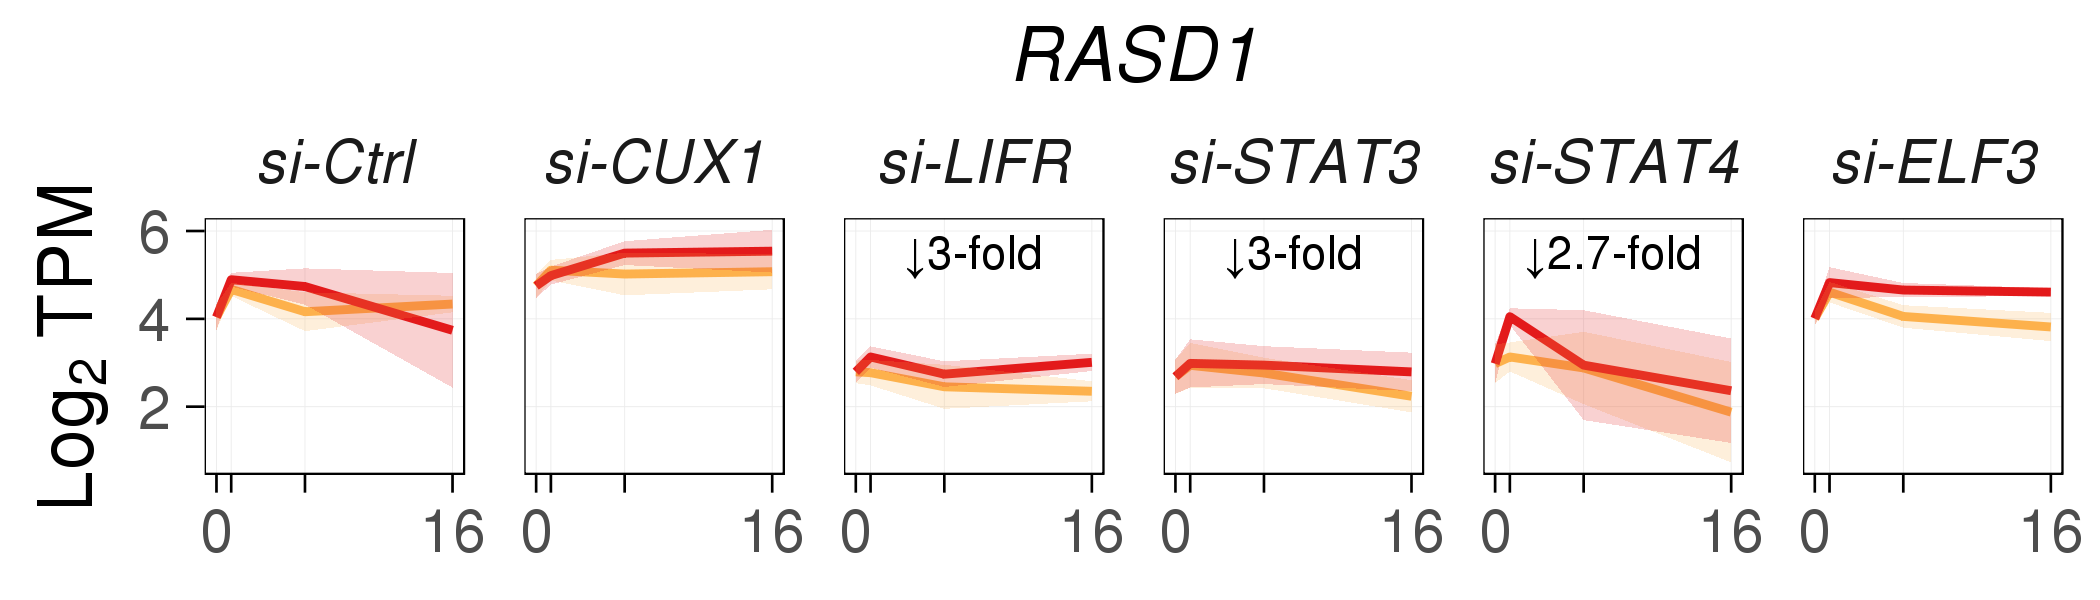

In [98]:
plot_sirna_gene <- function(this_gene, ylog2 = TRUE) {
  # this_gene <- "RASD1"
  this_ensembl <- names(which(gene_symbols == this_gene))
  # this_ensembl

  p_dat      <- sirna$meta_zero
  p_dat$gene <- as.numeric(sirna$log2tpm_zero[this_ensembl,])

  p_dat <- p_dat %>%
  # group_by(timefactor, dosefactor, sirna) %>%
  group_by(time, dosefactor, sirna) %>%
  summarise(
    mid = mean(gene),
    low = mean(gene) - sem(gene),
    high = mean(gene) + sem(gene)
  )

  p_dat$sirna <- factor(
    sprintf("si-%s", as.character(p_dat$sirna)),
    c("si-Ctrl", "si-CUX1", "si-LIFR", "si-STAT3", "si-STAT4", "si-ELF3")
  )
  
  updown <- c("↓", "↑")
  
  d_text <- sirna$fit1_top %>%
    dplyr::filter(Coef %in% sirnas) %>%
    dplyr::filter(ID %in% c(this_gene)) %>%
    dplyr::select(Coef, ID, logFC, CI.L, CI.R, P.Value, adj.P.Val) %>%
    reshape2::melt(id.vars = c("ID", "Coef")) %>%
    reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value") %>%
    mutate(FC = 2 ^ logFC) %>%
    mutate(signif = adj.P.Val < 0.05) %>%
    mutate(fc = sprintf(
      "%s%s-fold",
      updown[as.integer(logFC > 0) + 1],
      signif(2^abs(logFC), 2)
    ))
  
  d_text$sirna <- factor(
    sprintf("si-%s", as.character(d_text$Coef)),
    c("si-Ctrl", "si-CUX1", "si-LIFR", "si-STAT3", "si-STAT4", "si-ELF3")
  )
  
  print(d_text)
  
#   p_dat$sirna <- sprintf("si-%s", p_dat$sirna)

  # options(repr.plot.width = 7, repr.plot.height = 2)

  ylabel <- bquote("Log"[2]~"TPM")
  if (!ylog2) {
    p_dat$mid <- 2 ^ p_dat$mid
    p_dat$low <- 2 ^ p_dat$low
    p_dat$high <- 2 ^ p_dat$high
    ylabel <- "TPM"
  }
  
  p <- ggplot() +
  geom_line(
    data = p_dat,
    mapping = aes(x = time, y = mid, group = dosefactor, color = dosefactor),
    size = 1
  ) +
  geom_ribbon(
    data = p_dat,
    mapping = aes(x = time, ymin = low, ymax = high, group = dosefactor, fill = dosefactor),
    size = 0, alpha = 0.2
  ) +
  # facet_wrap(~ dosefactor) +
  facet_grid(~ sirna) +
  scale_x_continuous(
    breaks = c(0, 1, 6, 16),
    labels = c(0, "", "", 16)
  ) +
  scale_y_continuous(
    breaks = pretty_breaks(3)
  ) +
  # scale_color_manual(values = meta_colors$sirna) +
  scale_color_manual(values = c(
    "0" = '#FEB24C',
    "1" = '#E31A1C'
  )) +
  scale_fill_manual(values = c(
    "0" = '#FEB24C',
    "1" = '#E31A1C'
  )) +
  labs(x = NULL, y = ylabel, title = this_gene) +
  theme(
    plot.title = element_text(face = "italic"),
    panel.grid.major = element_line(size = 0.1),
    panel.spacing.x = unit(1, "lines"),
    strip.text = element_text(face = "italic"),
    legend.position = "none"
  )
  if (any(d_text$signif)) {
    p <- p + geom_text(
      data = d_text %>% filter(signif),
      mapping = aes(x = 8, y = Inf, label = fc),
      hjust = 0.5, vjust = 1.5
    ) 
  }
  return(p)
}

# # my_genes <- c("CXCL1", "CXCL2", "CXCL3", "IL6", "CXCL8", "CCL20", "LIF")
# plots <- lapply(my_genes, plot_sirna_gene)

# options(repr.plot.width = 7, repr.plot.height = 2 * length(my_genes))

# show_plot(patchwork::wrap_plots(plots, nrow = length(my_genes)))

options(repr.plot.width = 7, repr.plot.height = 2)

p <- plot_sirna_gene("RASD1")
show_plot(p, res = 300)

     ID  Coef      logFC       CI.L        CI.R     P.Value  adj.P.Val
1 CXCL6  CUX1 -0.9527548 -1.5258373 -0.37967217 0.001243285 0.03292027
2 CXCL6  ELF3 -0.2625919 -0.8356745  0.31049066 0.367137794 0.70578802
3 CXCL6  LIFR -0.3018946 -0.8749772  0.27118796 0.299989866 0.61559615
4 CXCL6 STAT3 -0.4222689 -0.9953515  0.15081369 0.147708634 0.63353091
5 CXCL6 STAT4 -0.5003083 -1.0733909  0.07277431 0.086671373 0.59204602
         FC signif        fc    sirna
1 0.5166450   TRUE ↓1.9-fold  si-CUX1
2 0.8335890  FALSE ↓1.2-fold  si-ELF3
3 0.8111864  FALSE ↓1.2-fold  si-LIFR
4 0.7462501  FALSE ↓1.3-fold si-STAT3
5 0.7069557  FALSE ↓1.4-fold si-STAT4


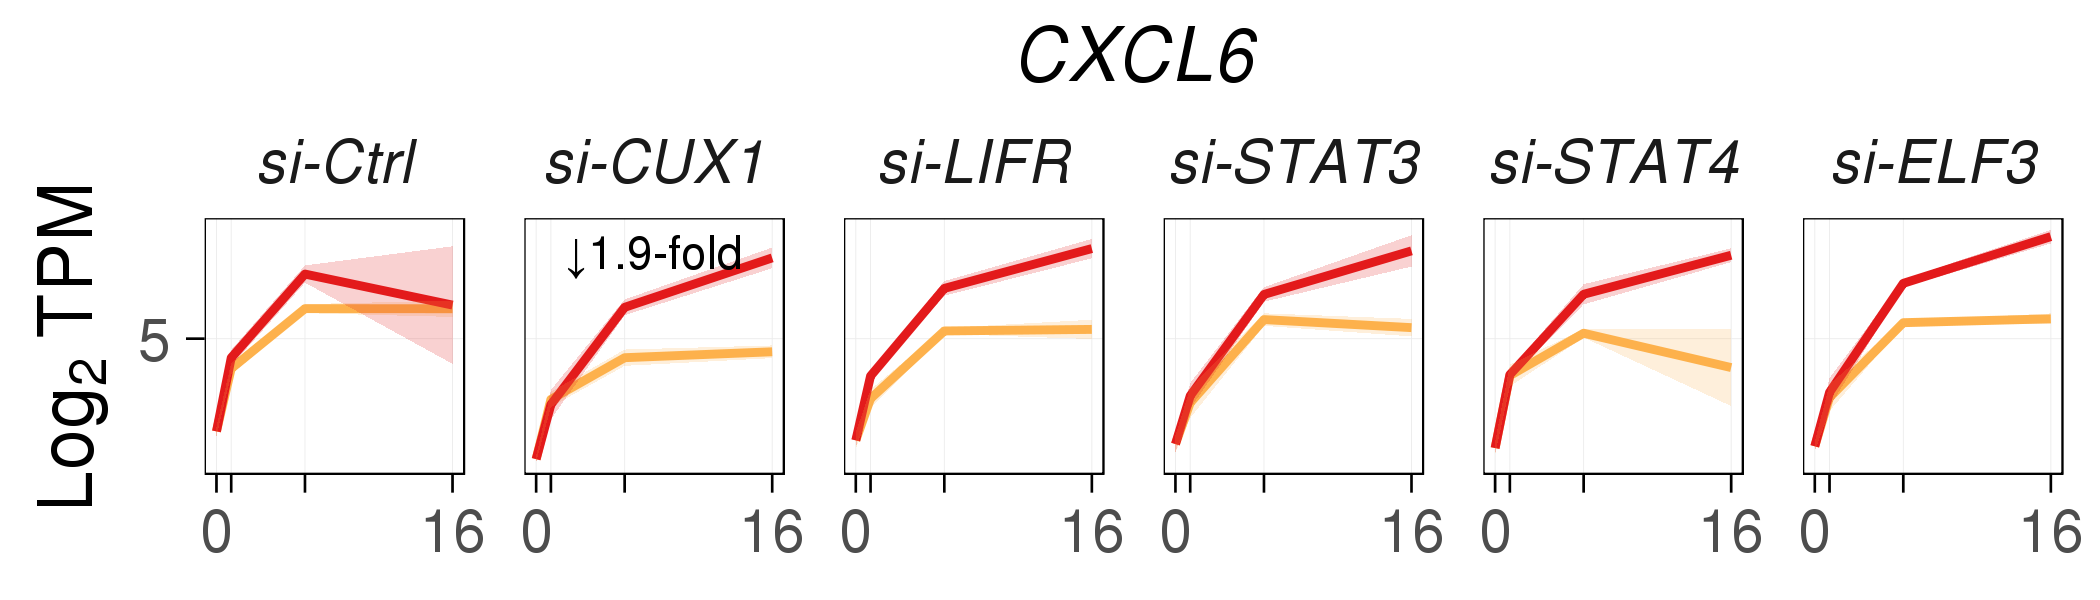

In [102]:
mygenes <- c("CXCL6") # c("CCL8", "CCL7", "CXCL1", "CXCL2", "CXCL3", "CXCL6")

for (g in mygenes) {
  p <- plot_sirna_gene(g, ylog2 = TRUE)
  show_plot(p, res = 300)
}

In [152]:
d %>% mutate(x = signif(2^abs(logFC), 3))

ID,Coef,logFC,CI.L,CI.R,adj.P.Val,FC,signif,x
RASD1,CUX1,0.763671431,0.2520086,1.2753343,6.574695e-02,1.6978058,FALSE,1.70
RASD1,ELF3,-0.004248066,-0.5159109,0.5074148,1.000000e+00,0.9970598,FALSE,1.00
RASD1,LIFR,-1.571337868,-2.0830007,-1.0596750,2.251570e-06,0.3364962,TRUE,2.97
RASD1,STAT3,-1.572649564,-2.0843124,-1.0609867,3.191212e-06,0.3361904,TRUE,2.97
RASD1,STAT4,-1.426421795,-1.9380847,-0.9147589,4.967788e-05,0.3720525,TRUE,2.69


Warning message:
“Removed 542 rows containing missing values (geom_point).”

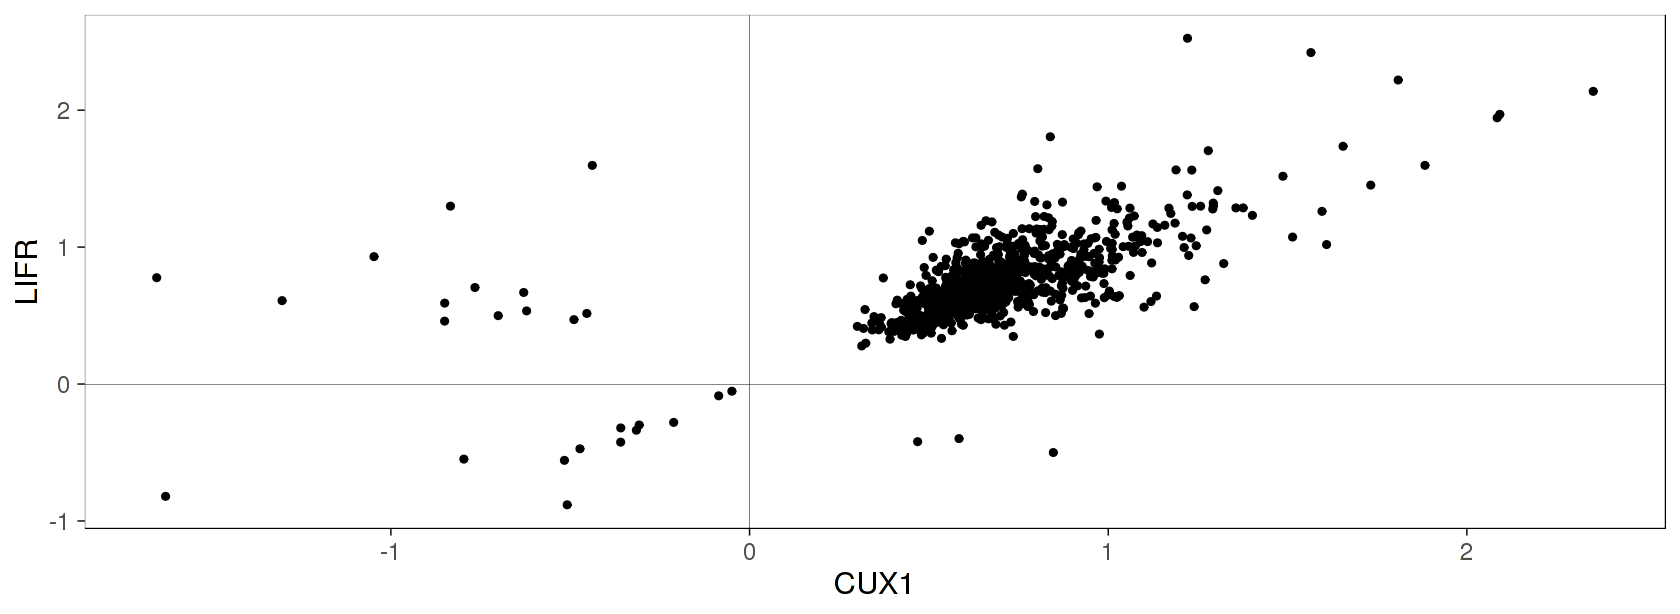

In [207]:
sirna$fit1_top %>%
filter(Coef %in% c("CUX1", "LIFR")) %>%
# filter(ID %in% d_genes) %>%
filter(adj.P.Val < 0.05) %>%
dplyr::select(ensembl_id, logFC, Coef) %>%
tidyr::spread(Coef, logFC) %>%
filter(CUX1 > -2) %>%
ggplot() +
geom_vline(xintercept = 0, size = 0.1) +
geom_hline(yintercept = 0, size = 0.1) +
aes(x = CUX1, y = LIFR) +
geom_point()

In [124]:
sirna$fit1_top %>% filter(ID %in% c("CXCL3"))

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
CXCL3,-0.451483901,-0.8069316,-0.096036185,4.151749,-2.50623894,0.01308225,0.1432057,-3.340509,ENSG00000163734,CUX1,1.3674460,1.749487,1.0688328
CXCL3,0.025914582,-0.3295331,0.381362298,4.151749,0.14385482,0.88577484,0.9863841,-6.318666,ENSG00000163734,ELF3,0.9821977,1.256607,0.7677123
CXCL3,0.021315031,-0.3341327,0.376762747,4.151749,0.11832219,0.90594333,0.9870966,-6.374305,ENSG00000163734,LIFR,0.9853342,1.260619,0.7701638
CXCL3,0.007828505,-0.3476192,0.363276220,4.151749,0.04345693,0.96538511,1.0000000,-6.290906,ENSG00000163734,STAT3,0.9945884,1.272459,0.7773972
CXCL3,-0.358885860,-0.7143336,-0.003438145,4.151749,-1.99221660,0.04784760,0.4779466,-4.331608,ENSG00000163734,STAT4,1.2824351,1.640725,1.0023860


In [104]:
x[x$ID == "CXCL2",]

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,signif,cumlogFC
CXCL2,2.8263,2.2128,3.4397,6.5967,9.0958,2.705e-16,6.296e-14,26.4819,ENSG00000081041,t6,TRUE,2.8263
CXCL2,3.4858,3.2281,3.7435,6.5967,26.7053,3.629e-62,3.607e-58,123.5850,ENSG00000081041,d1,TRUE,9.7682
CXCL2,4.7887,4.5310,5.0464,6.5967,36.6869,7.873e-82,7.825e-78,170.6637,ENSG00000081041,d10,TRUE,11.0711


In [134]:
d <- seriate_cols(
  d = dat_all %>% filter(ID %in% d_genes & coef %in% sirnas),
  col1 = "ID",
  col2 = "coef",
  value.var = "logFC",
  method = "PCA"
)
levels_sirna <- levels(d$ID)

d <- dat_all %>% filter(ID %in% d_genes)
d$ID <- factor(
  x = as.character(d$ID),
  levels = levels_sirna
)

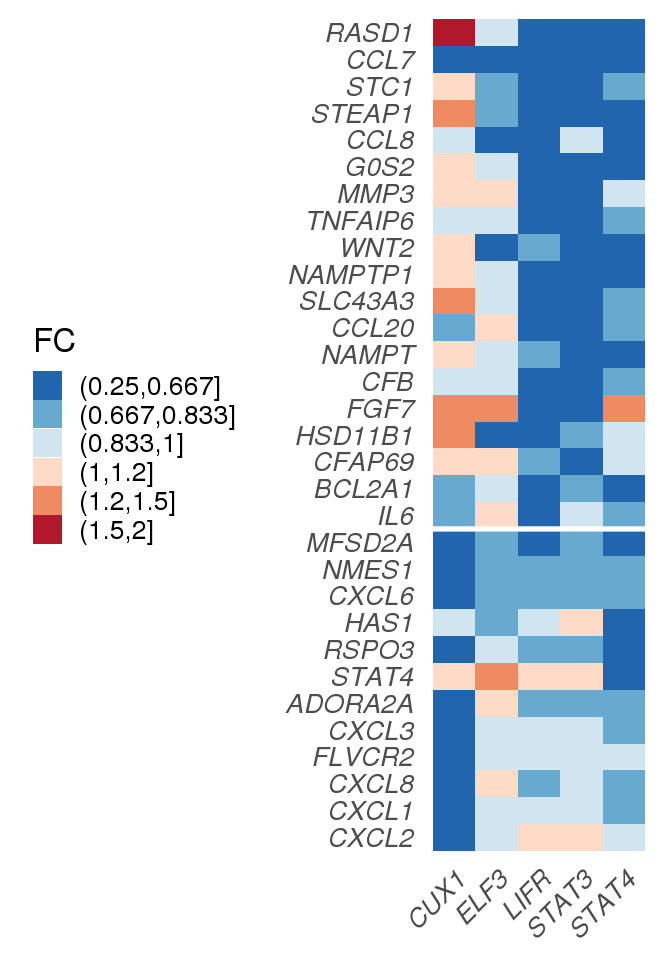

In [1506]:
# The heatmap does not look very good.

mypal <- "roma"
p1 <- d %>%
filter(coef %in% sirnas) %>%
mutate(fc = cut(2^logFC, breaks = c(1/4, 1/1.5, 1/1.2, 1, 2.4/2, 3/2, 2))) %>%
ggplot(aes(x = coef, y = ID, fill = fc)) +
geom_tile() +
# geom_point(
#   aes(color = abs(logFC) > log2(1.5)),
#   size = 0.5
# ) +
# scale_color_manual(
#   guide = FALSE,
#   values = c("FALSE" = NA, "TRUE" = "white")
# ) +
geom_hline(yintercept = 12.5, size = 1.5, color = "white") +
scale_fill_brewer(name = "FC", palette = "RdBu", direction = -1) +
# scale_fill_gradient2(
#   breaks = log2(c(1.5, 1 / c(1, 2, 4, 6, 8, 10, 12))),
#   limits = c(log2(1/4), NA),
#   labels = function(x) fractional(2 ^ x),
#   name = "FC",
# #   mid = "grey50", low = "red", high = "green"
#   low  = scico::scico(n = 9, palette = mypal)[9],
#   mid  = scico::scico(n = 9, palette = mypal)[5],
#   high = scico::scico(n = 9, palette = mypal)[1]
# ) +
theme_minimal(base_size = 20) +
theme(
  legend.position = "left",
  panel.grid = element_blank(),
  axis.text.x = element_text(face = "italic", angle = 45, hjust = 1),
  axis.text.y = element_text(face = "italic")
) +
labs(x = NULL, y = NULL)
#guides(fill = guide_colorbar(barheight = 1, barwidth = 8))

show_plot(p1)

Warning message:
“Removed 94 rows containing missing values (geom_point).”Warning message:
“Removed 8 rows containing missing values (geom_point).”

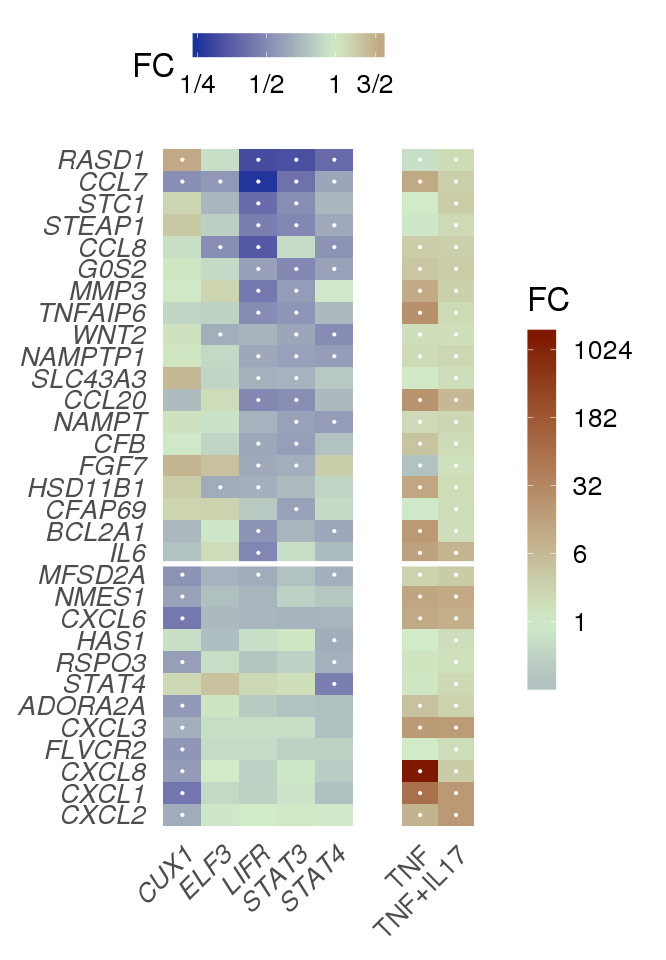

In [1484]:
# The heatmap does not look very good.

mypal <- "roma"
p1 <- d %>%
filter(coef %in% sirnas) %>%
ggplot(aes(x = coef, y = ID, fill = logFC)) +
geom_tile() +
geom_point(
  aes(color = abs(logFC) > log2(1.5)),
  size = 0.5
) +
scale_color_manual(
  guide = FALSE,
  values = c("FALSE" = NA, "TRUE" = "white")
) +
geom_hline(yintercept = 12.5, size = 1.5, color = "white") +
scale_fill_gradient2(
  breaks = log2(c(1.5, 1 / c(1, 2, 4, 6, 8, 10, 12))),
  limits = c(log2(1/4), NA),
  labels = function(x) fractional(2 ^ x),
  name = "FC",
#   mid = "grey50", low = "red", high = "green"
  low  = scico::scico(n = 9, palette = mypal)[9],
  mid  = scico::scico(n = 9, palette = mypal)[5],
  high = scico::scico(n = 9, palette = mypal)[1]
) +
theme_minimal(base_size = 20) +
theme(
  legend.position = "top",
  panel.grid = element_blank(),
  axis.text.x = element_text(face = "italic", angle = 45, hjust = 1),
  axis.text.y = element_text(face = "italic")
) +
labs(x = NULL, y = NULL) +
guides(fill = guide_colorbar(barheight = 1, barwidth = 8))

p2 <- d %>%
filter(!coef %in% sirnas) %>%
ggplot(aes(x = coef, y = ID, fill = logFC)) +
geom_tile() +
geom_point(
  aes(color = abs(logFC) > log2(1.5)),
  size = 0.5
) +
scale_color_manual(
  guide = FALSE,
  values = c("FALSE" = NA, "TRUE" = "white")
) +
geom_hline(yintercept = 12.5, size = 1.5, color = "white") +
scale_fill_gradient2(
#   breaks = log2(1 / c(1, 2, 4, 6, 8, 10, 12)),
#   limits = c(log2(1/4), NA),
  labels = function(x) fractional(ceiling(2 ^ x)),
  name = "FC",
#   mid = "grey50", low = "red", high = "green"
  low  = scico::scico(n = 9, palette = mypal)[9],
  mid  = scico::scico(n = 9, palette = mypal)[5],
  high = scico::scico(n = 9, palette = mypal)[1]
) +
theme_minimal(base_size = 20) +
theme(
  panel.grid = element_blank(),
  axis.text.x = element_text(angle = 45, hjust = 1),
#   axis.text.y = element_text(face = "italic")
    axis.text.y = element_blank()
) +
labs(x = NULL, y = NULL) +
guides(fill = guide_colorbar(barheight = 15))

options(repr.plot.width = 5.55, repr.plot.height = 8)

show_plot(p1 + p2 + patchwork::plot_layout(widths = c(2.5, 1)))

In [1422]:
genes_group1 <- levels(d$ID)[1:12]
cat(genes_group1, "\n")
genes_group2 <- setdiff(levels(d$ID), genes_group1)
cat(genes_group2)

CXCL2 CXCL1 CXCL8 FLVCR2 CXCL3 ADORA2A STAT4 RSPO3 HAS1 CXCL6 NMES1 MFSD2A 
IL6 BCL2A1 CFAP69 HSD11B1 FGF7 CFB NAMPT CCL20 SLC43A3 NAMPTP1 WNT2 TNFAIP6 MMP3 G0S2 CCL8 STEAP1 STC1 CCL7 RASD1

IL17 increases expression of *CXCL1* 17-fold and siRNA knockdown of *CUX1* brings down *CXCL1* expression 2.3-fold.

In [1360]:
d_effects <- d %>%
filter(coef %in% c("TNF+IL17", "CUX1")) %>%
dplyr::select(ID, coef, logFC) %>% tidyr::spread(coef, logFC) %>%
arrange(CUX1)
rownames(d_effects) <- d_effects$ID
d_effects$ID <- NULL
d_effects <- apply(d_effects, 2, function(x) sigfig(2^x))
d_effects

,CUX1,TNF+IL17
CXCL1,0.43,17
CXCL6,0.44,7.8
CCL7,0.52,2.6
MFSD2A,0.53,3.0
FLVCR2,0.55,1.7
ADORA2A,0.56,2.4
CXCL8,0.57,3.0
RSPO3,0.58,1.5
NMES1,0.59,9.6
CXCL2,0.63,17


In [163]:
plot_sirna_dose <- function(this_sirna) {
  x <- topTable(sirna$fit1, coef = this_sirna, number = 1e6)
  x <- x[order(rownames(x)),]
  y <- topTable(fit_e, coef = "d1", number = 1e6)
  y <- y[order(rownames(y)),]
  both <- intersect(rownames(x), rownames(y))
  x <- x[both,]
  y <- y[both,]
  stopifnot(all(rownames(x) == rownames(y)))
  # for plotting
  dat <- data.frame(
    "gene"      = y$ID,
    "IL17"      = y$logFC,
    "IL17_pval" = y$P.Value
  )
  dat[[this_sirna]] <- x$logFC
  dat[[sprintf("%s_pval", this_sirna)]] <- x$P.Value
  dat[["selected"]] <- dat$gene %in% d_genes
  
  dat_text <- dat[dat[["IL17"]] > log2(1.5) & dat[[this_sirna]] < log2(1 / 1.3),]

  # options(repr.plot.width = 3, repr.plot.height = 3)

  limit_low  <- log2(1 / 1.5)
  limit_high <- log2(1.5)
  
  dat <- dat[abs(dat[["IL17"]]) > limit_high | abs(dat[[this_sirna]]) > limit_high,]
  dat <- dat[order(dat$selected, decreasing = FALSE),]
  
  dat$group <- "none"
  dat$group[dat$gene %in% genes_group1] <- "a"
  dat$group[dat$gene %in% genes_group2] <- "b"
  
  ggplot() +
  geom_rect(
    mapping = aes(
      ymin = log2(1 / 1.5),
      ymax = log2(1.5),
      xmin = -Inf,
      xmax = Inf
    ),
    fill = 'grey90'
  ) +
  geom_rect(
    mapping = aes(
      xmin = log2(1 / 1.5),
      xmax = log2(1.5),
      ymin = -Inf,
      ymax = Inf
    ),
    fill = 'grey90'
  ) +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_vline(xintercept = 0, size = 0.2) +
  geom_point(
    data = dat,
    mapping = aes_string(
      y = "IL17", x = this_sirna, fill = "group", size = "selected"
    ),
    shape = 21
  ) +
  scale_fill_manual(
    values = c(
      "none" = "black",
      "a" = "pink",
      "b" = "white"
    )
  ) +
#   scale_color_manual(values = c("black", "red")) +
  scale_size_manual(values = c(1, 2.5)) +
  # coord_equal() +
  # geom_text(
  #   data = dat_text,
  #   mapping = aes(y = IL17, x = CUX1, label = gene),
  #   size = 3, nudge_x = -0.25
  # ) +
  scale_x_continuous(labels = function(x) fractional(2^x)) +
  scale_y_continuous(labels = function(x) fractional(2^x)) +
  labs(y = "TNF + IL17") +
  theme(legend.position = "none", axis.title.x = element_text(face = "italic"))
}
                     
options(repr.plot.width = 15, repr.plot.height = 3)
p1 <- plot_sirna_dose("CUX1")
p2 <- plot_sirna_dose("ELF3") + labs(y = NULL)
p3 <- plot_sirna_dose("STAT4") + labs(y = NULL)
p4 <- plot_sirna_dose("STAT3") + labs(y = NULL)
p5 <- plot_sirna_dose("LIFR") + labs(y = NULL)
show_plot(p1 + p2 + p3 + p4 + p5 + patchwork::plot_layout(ncol = 5))

ERROR: Error in dat$gene %in% genes_group1: object 'genes_group1' not found


Get effect of TNF at 24h.

Get TNF+IL17 versus TNF effect.

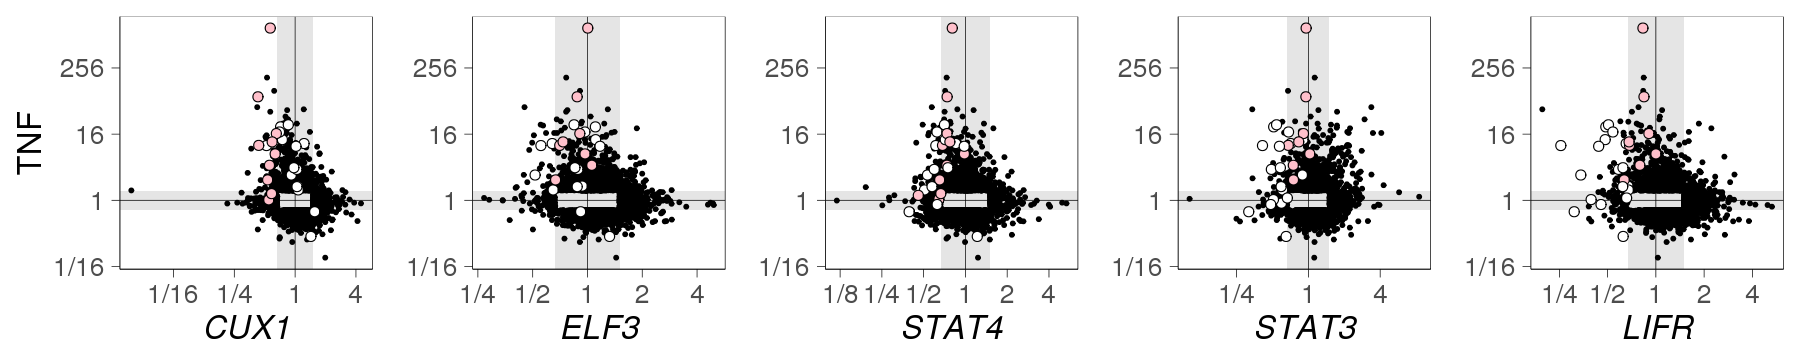

In [1449]:
plot_sirna_tnf <- function(this_sirna) {
  x <- topTable(sirna$fit1, coef = this_sirna, number = 1e6)
  x <- x[order(rownames(x)),]
  y <- topTable(con_e, coef = 1, number = 1e6)
  y <- y[order(rownames(y)),]
  both <- intersect(rownames(x), rownames(y))
  x <- x[both,]
  y <- y[both,]
  stopifnot(all(rownames(x) == rownames(y)))
  # for plotting
  dat <- data.frame(
    "gene"     = y$ID,
    "TNF"      = y$logFC,
    "TNF_pval" = y$P.Value
  )
  dat[[this_sirna]] <- x$logFC
  dat[[sprintf("%s_pval", this_sirna)]] <- x$P.Value
  dat[["selected"]] <- dat$gene %in% d_genes

  dat_text <- dat[dat[["TNF"]] > log2(1.5) & dat[[this_sirna]] < log2(1 / 1.3),]

  # options(repr.plot.width = 3, repr.plot.height = 3)

  limit_low  <- log2(1 / 1.5)
  limit_high <- log2(1.5)
  
  dat <- dat[abs(dat[["TNF"]]) > limit_high | abs(dat[[this_sirna]]) > limit_high,]
  dat <- dat[order(dat$selected, decreasing = FALSE),]
  
  dat$group <- "none"
  dat$group[dat$gene %in% genes_group1] <- "a"
  dat$group[dat$gene %in% genes_group2] <- "b"
  
  ggplot() +
  geom_rect(
    mapping = aes(
      ymin = log2(1 / 1.5),
      ymax = log2(1.5),
      xmin = -Inf,
      xmax = Inf
    ),
    fill = 'grey90'
  ) +
  geom_rect(
    mapping = aes(
      xmin = log2(1 / 1.5),
      xmax = log2(1.5),
      ymin = -Inf,
      ymax = Inf
    ),
    fill = 'grey90'
  ) +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_vline(xintercept = 0, size = 0.2) +
#   geom_point(
#     data = dat[abs(dat[["TNF"]]) > limit_high | abs(dat[[this_sirna]]) > limit_high,],
#     mapping = aes_string(y = "TNF", x = this_sirna),
#     size = 0.5
#   ) +
  geom_point(
    data = dat,
    mapping = aes_string(
      y = "TNF", x = this_sirna, fill = "group", size = "selected"
    ),
    shape = 21
  ) +
  scale_fill_manual(
    values = c(
      "none" = "black",
      "a" = "pink",
      "b" = "white"
    )
  ) +
#   scale_color_manual(values = c("black", "red")) +
  scale_size_manual(values = c(1, 2.5)) +
  # coord_equal() +
  # geom_text(
  #   data = dat_text,
  #   mapping = aes(y = IL17, x = CUX1, label = gene),
  #   size = 3, nudge_x = -0.25
  # ) +
#   scale_color_discrete(name = "signif") +
  scale_x_continuous(labels = function(x) fractional(2^x)) +
  scale_y_continuous(labels = function(x) fractional(2^x)) +
  labs(y = "TNF") +
  theme(legend.position = "none", axis.title.x = element_text(face = "italic"))
}
                     
options(repr.plot.width = 15, repr.plot.height = 3)
p1 <- plot_sirna_tnf("CUX1")
p2 <- plot_sirna_tnf("ELF3") + labs(y = NULL)
p3 <- plot_sirna_tnf("STAT4") + labs(y = NULL)
p4 <- plot_sirna_tnf("STAT3") + labs(y = NULL)
p5 <- plot_sirna_tnf("LIFR") + labs(y = NULL)
show_plot(p1 + p2 + p3 + p4 + p5 + patchwork::plot_layout(ncol = 5))